In [7]:
pip install lightgbm xgboost


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


In [9]:
# Google Colaboratoryで作業する場合のみ実行
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/compe2"

# データの読み込み
INPUT_DIR = "./input/"

train = pd.read_csv(INPUT_DIR + "train.csv")
test = pd.read_csv(INPUT_DIR + "test.csv")
sample_sub = pd.read_csv(INPUT_DIR + "sample_submission.csv")

# データの基本情報
print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")

# 上位5行を表示
train.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/compe2
Train shape: (171202, 51)
Test shape: (61500, 50)


SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           0       0         Cash loans           F            N   
1           1       0         Cash loans           F            N   
2           2       0         Cash loans           F            N   
3           3       0         Cash loans           F            N   
4           4       1         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               N             0          112500.0    755190.0      36328.5   
1               Y             0          225000.0    585000.0      16893.0   
2               Y             0           54000.0    334152.0      18256.5   
3               Y             0           67500.0    152820.0       8901.0   
4               N             0          157500.0    271066.5      21546.0   

   ...  EXT_SOURCE_3 OBS_30_CNT_SOCIAL_CIRCLE DEF_30_CNT_SOCIAL_CIRCLE  \
0  ...           NaN                      0.0                      0.0   
1  ...      0.553165                      0.0                      0.0   
2  ...           NaN                      4.0                      0.0   
3  ...      0.767523                      0.0                      0.0   
4  ...      0.669057                      0.0                      0.0   

  OBS_60_CNT_SOCIAL_CIRCLE DEF_60_CNT_SOCIAL_CIRCLE DAYS_LAST_PHONE_CHANGE  \
0                      0.0                      0.0                 -292.0   
1                      0.0                      0.0                 -617.0   
2                      4.0                      0.0                 -542.0   
3                      0.0                      0.0                    0.0   
4                      0.0                      0.0                -1243.0   

   AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_MON  \
0                         NaN                        NaN   
1                         0.0                        0.0   
2                         NaN                        NaN   
3                         0.0                        0.0   
4                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        NaN                         NaN  
1                        0.0                         1.0  
2                        NaN                         NaN  
3                        0.0                         0.0  
4                        0.0                         4.0  

[5 rows x 51 columns]

In [10]:
# 欠損値の確認
missing_train = train.isnull().sum().sort_values(ascending=False)
missing_test = test.isnull().sum().sort_values(ascending=False)

print("Train Missing Values:\n", missing_train[missing_train > 0])
print("\nTest Missing Values:\n", missing_test[missing_test > 0])


Train Missing Values:
 EXT_SOURCE_1                  118928
OWN_CAR_AGE                   112992
EXT_SOURCE_3                   54586
OCCUPATION_TYPE                53745
FLAG_OWN_CAR                   34241
FLAG_OWN_REALTY                34241
AMT_REQ_CREDIT_BUREAU_YEAR     23116
AMT_REQ_CREDIT_BUREAU_QRT      23116
AMT_REQ_CREDIT_BUREAU_HOUR     23116
AMT_REQ_CREDIT_BUREAU_MON      23116
NAME_TYPE_SUITE                  747
OBS_30_CNT_SOCIAL_CIRCLE         560
OBS_60_CNT_SOCIAL_CIRCLE         560
DEF_30_CNT_SOCIAL_CIRCLE         560
DEF_60_CNT_SOCIAL_CIRCLE         560
EXT_SOURCE_2                     369
AMT_GOODS_PRICE                  163
AMT_ANNUITY                        6
CNT_FAM_MEMBERS                    2
DAYS_LAST_PHONE_CHANGE             1
dtype: int64

Test Missing Values:
 EXT_SOURCE_1                  42912
OWN_CAR_AGE                   40909
EXT_SOURCE_3                  19690
OCCUPATION_TYPE               18734
FLAG_OWN_CAR                  12334
FLAG_OWN_REALTY      

In [11]:
# コピーを作成
train_processed = train.copy()
test_processed = test.copy()

# 数値型特徴量の補完（中央値）
num_cols = train_processed.select_dtypes(include=['float64', 'int64']).columns.tolist()
num_cols.remove('TARGET')  # 目的変数は除外

for col in num_cols:
    median = train_processed[col].median()
    train_processed[col].fillna(median, inplace=True)
    test_processed[col].fillna(median, inplace=True)

# カテゴリ型特徴量の補完
cat_cols = train_processed.select_dtypes(include=['object']).columns.tolist()
for col in cat_cols:
    train_processed[col].fillna('Missing', inplace=True)
    test_processed[col].fillna('Missing', inplace=True)

# OWN_CAR_AGEの外れ値処理（60以上を欠損値として扱い中央値で補完）
if train_processed['OWN_CAR_AGE'].max() >= 60:
    train_processed.loc[train_processed["OWN_CAR_AGE"] >= 60, "OWN_CAR_AGE"] = np.nan
    test_processed.loc[test_processed["OWN_CAR_AGE"] >= 60, "OWN_CAR_AGE"] = np.nan
    median_car_age = train_processed['OWN_CAR_AGE'].median()
    train_processed['OWN_CAR_AGE'].fillna(median_car_age, inplace=True)
    test_processed['OWN_CAR_AGE'].fillna(median_car_age, inplace=True)

# 再度欠損値を確認
print("After imputation, missing values in train:")
print(train_processed.isnull().sum().max())


After imputation, missing values in train:
0


In [12]:
# バイナリカテゴリ型特徴量のエンコード
binary_cols = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']
le = LabelEncoder()
for col in binary_cols:
    train_processed[col] = le.fit_transform(train_processed[col])
    test_processed[col] = le.transform(test_processed[col])

# その他のカテゴリ型特徴量のカウントエンコーディング
other_cat_cols = [col for col in cat_cols if col not in binary_cols]
for col in other_cat_cols:
    freq_encoding = train_processed[col].value_counts()
    train_processed[col] = train_processed[col].map(freq_encoding)
    test_processed[col] = test_processed[col].map(freq_encoding)
    # 欠損値が発生した場合は0で埋める
    train_processed[col].fillna(0, inplace=True)
    test_processed[col].fillna(0, inplace=True)


In [13]:
# 例: AMT_INCOME_TOTALの外れ値をIQRで除外
Q1 = train_processed['AMT_INCOME_TOTAL'].quantile(0.25)
Q3 = train_processed['AMT_INCOME_TOTAL'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 外れ値を中央値で補完
train_processed['AMT_INCOME_TOTAL'] = np.where(
    (train_processed['AMT_INCOME_TOTAL'] < lower_bound) | (train_processed['AMT_INCOME_TOTAL'] > upper_bound),
    train_processed['AMT_INCOME_TOTAL'].median(),
    train_processed['AMT_INCOME_TOTAL']
)

test_processed['AMT_INCOME_TOTAL'] = np.where(
    (test_processed['AMT_INCOME_TOTAL'] < lower_bound) | (test_processed['AMT_INCOME_TOTAL'] > upper_bound),
    test_processed['AMT_INCOME_TOTAL'].median(),
    test_processed['AMT_INCOME_TOTAL']
)


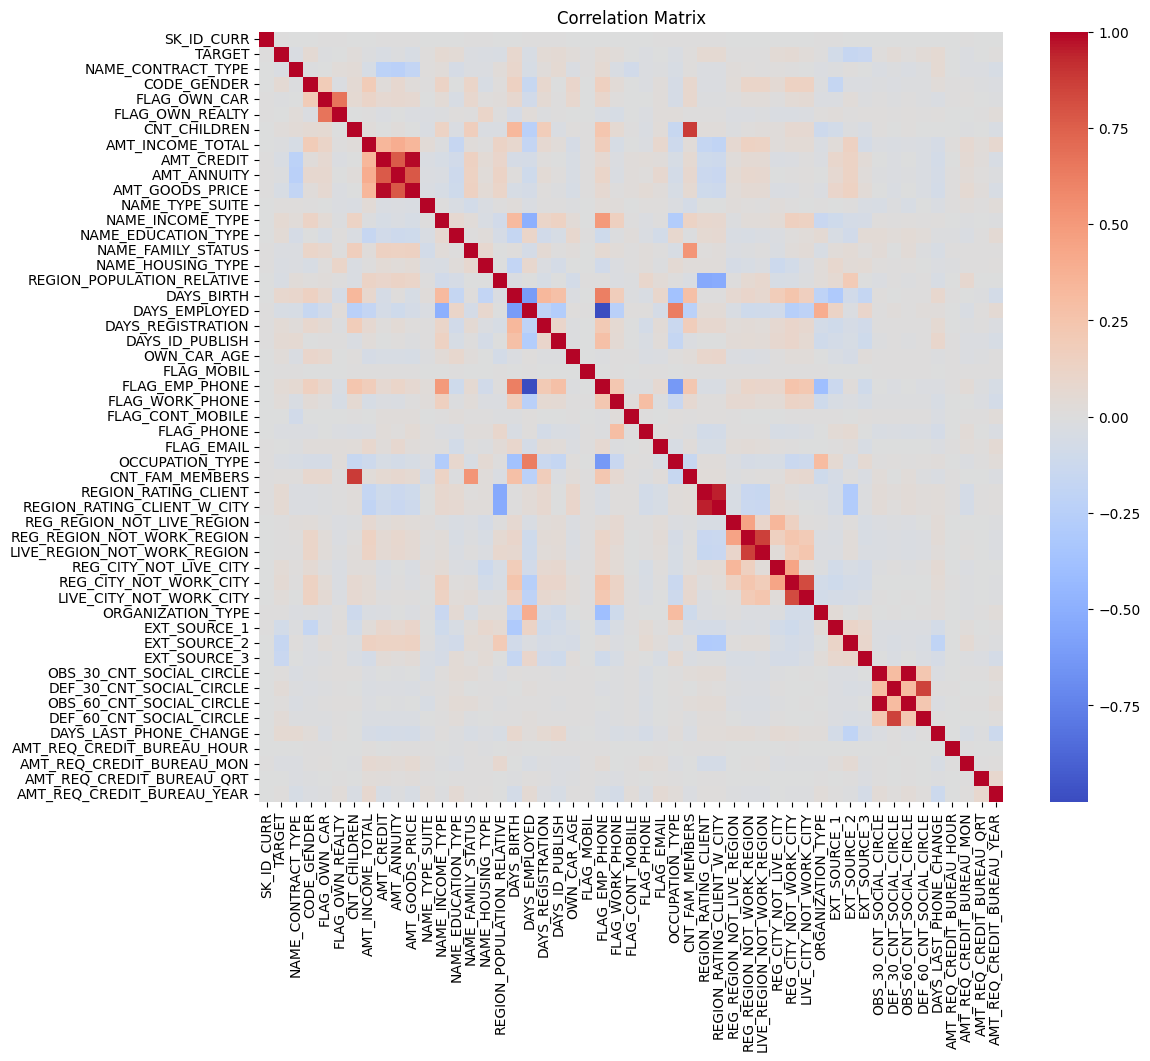

TARGET                         1.000000
EXT_SOURCE_2                   0.162383
EXT_SOURCE_3                   0.142190
EXT_SOURCE_1                   0.081994
DAYS_BIRTH                     0.079541
REGION_RATING_CLIENT_W_CITY    0.061132
REGION_RATING_CLIENT           0.058984
NAME_INCOME_TYPE               0.058168
DAYS_LAST_PHONE_CHANGE         0.055195
CODE_GENDER                    0.054420
DAYS_ID_PUBLISH                0.052567
REG_CITY_NOT_WORK_CITY         0.049438
FLAG_EMP_PHONE                 0.045646
DAYS_EMPLOYED                  0.044592
REG_CITY_NOT_LIVE_CITY         0.043829
NAME_EDUCATION_TYPE            0.042734
AMT_GOODS_PRICE                0.041887
DAYS_REGISTRATION              0.041669
REGION_POPULATION_RELATIVE     0.038259
DEF_60_CNT_SOCIAL_CIRCLE       0.033185
DEF_30_CNT_SOCIAL_CIRCLE       0.032940
AMT_CREDIT                     0.032727
LIVE_CITY_NOT_WORK_CITY        0.030409
NAME_CONTRACT_TYPE             0.029946
NAME_HOUSING_TYPE              0.029620


In [15]:
# 相関係数の確認
corr_matrix = train_processed.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# ターゲットとの相関が高い特徴量を選択
target_corr = corr_matrix['TARGET'].abs().sort_values(ascending=False)
print(target_corr)

# 相関が0.05以上の特徴量を選択（閾値は調整可能）
selected_features_corr = target_corr[target_corr > 0.05].index.tolist()

# 'TARGET'と'SK_ID_CURR'を除外（存在する場合のみ）
for col in ['TARGET', 'SK_ID_CURR']:
    if col in selected_features_corr:
        selected_features_corr.remove(col)

print(f"Selected Features based on Correlation ({len(selected_features_corr)}): {selected_features_corr}")



In [16]:
# 相互作用特徴量の追加
train_processed['INCOME_CHILD_RATIO'] = train_processed['AMT_INCOME_TOTAL'] / (train_processed['CNT_CHILDREN'] + 1)
test_processed['INCOME_CHILD_RATIO'] = test_processed['AMT_INCOME_TOTAL'] / (test_processed['CNT_CHILDREN'] + 1)

# 他の特徴量の追加例
train_processed['CREDIT_ANNUITY_RATIO'] = train_processed['AMT_CREDIT'] / (train_processed['AMT_ANNUITY'] + 1)
test_processed['CREDIT_ANNUITY_RATIO'] = test_processed['AMT_CREDIT'] / (test_processed['AMT_ANNUITY'] + 1)

# 新たに追加した特徴量を選択リストに追加
selected_features += ['INCOME_CHILD_RATIO', 'CREDIT_ANNUITY_RATIO']


In [17]:
# 特徴量のスケーリング
scaler = StandardScaler()
train_processed[selected_features] = scaler.fit_transform(train_processed[selected_features])
test_processed[selected_features] = scaler.transform(test_processed[selected_features])


In [18]:
# 目的変数と説明変数の分割
X = train_processed[selected_features]
y = train_processed['TARGET']
X_test_final = test_processed[selected_features]

# 訓練データと検証データに分割
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# モデルの初期化
models = {
    'LogisticRegression': LogisticRegression(random_state=42, max_iter=1000),
    'MLPClassifier': MLPClassifier(random_state=42, max_iter=500),
    'RandomForest': RandomForestClassifier(random_state=42, n_estimators=100),
    'XGBoost': XGBClassifier(
        random_state=42,
        n_estimators=50,
        learning_rate=0.1,
        max_depth=5,
        use_label_encoder=False,
        eval_metric='auc'
    ),
    'LightGBM': LGBMClassifier(
        random_state=42,
        n_estimators=100,
        learning_rate=0.1,
        max_depth=7
    )
}

# 各モデルのトレーニングと評価
model_performance = {}

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)

    # 訓練データの予測
    y_train_pred = model.predict_proba(X_train)[:, 1]
    # 検証データの予測
    y_valid_pred = model.predict_proba(X_valid)[:, 1]

    # AUCスコアの計算
    train_auc = roc_auc_score(y_train, y_train_pred)
    valid_auc = roc_auc_score(y_valid, y_valid_pred)

    model_performance[name] = {
        'Train AUC': train_auc,
        'Valid AUC': valid_auc
    }
    print(f"{name} - Train AUC: {train_auc:.4f}, Valid AUC: {valid_auc:.4f}\n")

# モデルの性能比較
performance_df = pd.DataFrame(model_performance).T
print(performance_df)


Training LogisticRegression...
LogisticRegression - Train AUC: 0.7207, Valid AUC: 0.7174

Training MLPClassifier...
MLPClassifier - Train AUC: 0.7465, Valid AUC: 0.7195

Training RandomForest...
RandomForest - Train AUC: 1.0000, Valid AUC: 0.7058

Training XGBoost...
XGBoost - Train AUC: 0.7636, Valid AUC: 0.7392

Training LightGBM...
[LightGBM] [Info] Number of positive: 9675, number of negative: 110166
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008565 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1996
[LightGBM] [Info] Number of data points in the train set: 119841, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080732 -> initscore=-2.432443
[LightGBM] [Info] Start training from score -2.432443
LightGBM - Train AUC: 0.8027, Valid AUC: 0.7468

                    Train AUC  Valid AUC
LogisticRegres

In [19]:
# アンサンブルモデル（Voting Classifier）の構築
voting_clf = VotingClassifier(
    estimators=[
        ('lr', models['LogisticRegression']),
        ('mlp', models['MLPClassifier']),
        ('rf', models['RandomForest']),
        ('xgb', models['XGBoost']),
        ('lgbm', models['LightGBM'])
    ],
    voting='soft'  # ソフト投票
)

print("Training Voting Classifier...")
voting_clf.fit(X_train, y_train)

# アンサンブルモデルの予測
y_train_pred_vc = voting_clf.predict_proba(X_train)[:, 1]
y_valid_pred_vc = voting_clf.predict_proba(X_valid)[:, 1]

# AUCスコアの計算
train_auc_vc = roc_auc_score(y_train, y_train_pred_vc)
valid_auc_vc = roc_auc_score(y_valid, y_valid_pred_vc)

print(f"VotingClassifier - Train AUC: {train_auc_vc:.4f}, Valid AUC: {valid_auc_vc:.4f}")


Training Voting Classifier...
[LightGBM] [Info] Number of positive: 9675, number of negative: 110166
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012792 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1996
[LightGBM] [Info] Number of data points in the train set: 119841, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080732 -> initscore=-2.432443
[LightGBM] [Info] Start training from score -2.432443
VotingClassifier - Train AUC: 0.9772, Valid AUC: 0.7382


In [20]:
# 最適なモデルの選択（例としてアンサンブルモデルを使用）
final_model = voting_clf

# 全データで再トレーニング（必要に応じて）
final_model.fit(X, y)

# テストデータに対する予測
test_pred = final_model.predict_proba(X_test_final)[:, 1]

# 提出用ファイルの作成
sample_sub['TARGET'] = test_pred
sample_sub.to_csv('submission1.csv', index=False)
print("submission.csv が作成されました。")


[LightGBM] [Info] Number of positive: 13821, number of negative: 157381
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013174 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2003
[LightGBM] [Info] Number of data points in the train set: 171202, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432480
[LightGBM] [Info] Start training from score -2.432480
submission.csv が作成されました。


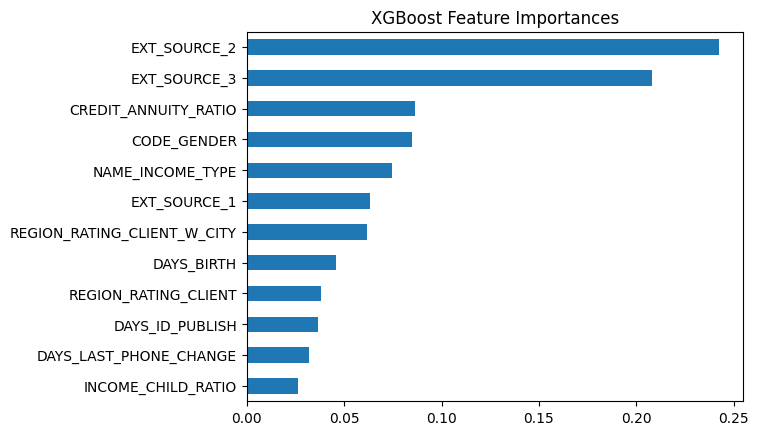

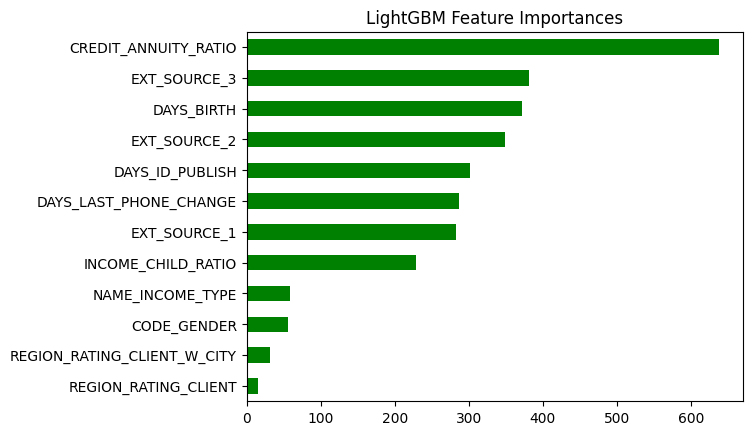

In [21]:
# XGBoostの特徴量重要度
xgb_feature_importances = pd.Series(models['XGBoost'].feature_importances_, index=X.columns)
xgb_feature_importances.sort_values(ascending=False).head(20).plot(kind='barh')
plt.title('XGBoost Feature Importances')
plt.gca().invert_yaxis()
plt.show()

# LightGBMの特徴量重要度
lgbm_feature_importances = pd.Series(models['LightGBM'].feature_importances_, index=X.columns)
lgbm_feature_importances.sort_values(ascending=False).head(20).plot(kind='barh', color='green')
plt.title('LightGBM Feature Importances')
plt.gca().invert_yaxis()
plt.show()


In [22]:
# 各モデルの特徴量重要度を数値として出力

# RandomForestの特徴量重要度
rf_importances = pd.Series(models['RandomForest'].feature_importances_, index=X.columns).sort_values(ascending=False)
print("RandomForest Feature Importances:")
print(rf_importances.to_frame('Importance').reset_index().rename(columns={'index': 'Feature'}))

# XGBoostの特徴量重要度
xgb_importances = pd.Series(models['XGBoost'].feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nXGBoost Feature Importances:")
print(xgb_importances.to_frame('Importance').reset_index().rename(columns={'index': 'Feature'}))

# LightGBMの特徴量重要度
lgbm_importances = pd.Series(models['LightGBM'].feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nLightGBM Feature Importances:")
print(lgbm_importances.to_frame('Importance').reset_index().rename(columns={'index': 'Feature'}))


RandomForest Feature Importances:
                        Feature  Importance
0                  EXT_SOURCE_2    0.161135
1                    DAYS_BIRTH    0.135140
2          CREDIT_ANNUITY_RATIO    0.135115
3               DAYS_ID_PUBLISH    0.131361
4        DAYS_LAST_PHONE_CHANGE    0.116595
5                  EXT_SOURCE_3    0.110564
6            INCOME_CHILD_RATIO    0.095496
7                  EXT_SOURCE_1    0.057395
8              NAME_INCOME_TYPE    0.021498
9   REGION_RATING_CLIENT_W_CITY    0.012584
10         REGION_RATING_CLIENT    0.012423
11                  CODE_GENDER    0.010695

XGBoost Feature Importances:
                        Feature  Importance
0                  EXT_SOURCE_2    0.242458
1                  EXT_SOURCE_3    0.208221
2          CREDIT_ANNUITY_RATIO    0.086566
3                   CODE_GENDER    0.084852
4              NAME_INCOME_TYPE    0.074360
5                  EXT_SOURCE_1    0.063171
6   REGION_RATING_CLIENT_W_CITY    0.061621
7           

Train shape: (171202, 51)
Test shape: (61500, 50)
Train Missing Values:
 EXT_SOURCE_1                  118928
OWN_CAR_AGE                   112992
EXT_SOURCE_3                   54586
OCCUPATION_TYPE                53745
FLAG_OWN_CAR                   34241
FLAG_OWN_REALTY                34241
AMT_REQ_CREDIT_BUREAU_YEAR     23116
AMT_REQ_CREDIT_BUREAU_QRT      23116
AMT_REQ_CREDIT_BUREAU_HOUR     23116
AMT_REQ_CREDIT_BUREAU_MON      23116
NAME_TYPE_SUITE                  747
OBS_30_CNT_SOCIAL_CIRCLE         560
OBS_60_CNT_SOCIAL_CIRCLE         560
DEF_30_CNT_SOCIAL_CIRCLE         560
DEF_60_CNT_SOCIAL_CIRCLE         560
EXT_SOURCE_2                     369
AMT_GOODS_PRICE                  163
AMT_ANNUITY                        6
CNT_FAM_MEMBERS                    2
DAYS_LAST_PHONE_CHANGE             1
dtype: int64

Test Missing Values:
 EXT_SOURCE_1                  42912
OWN_CAR_AGE                   40909
EXT_SOURCE_3                  19690
OCCUPATION_TYPE               18734
FLAG_OW

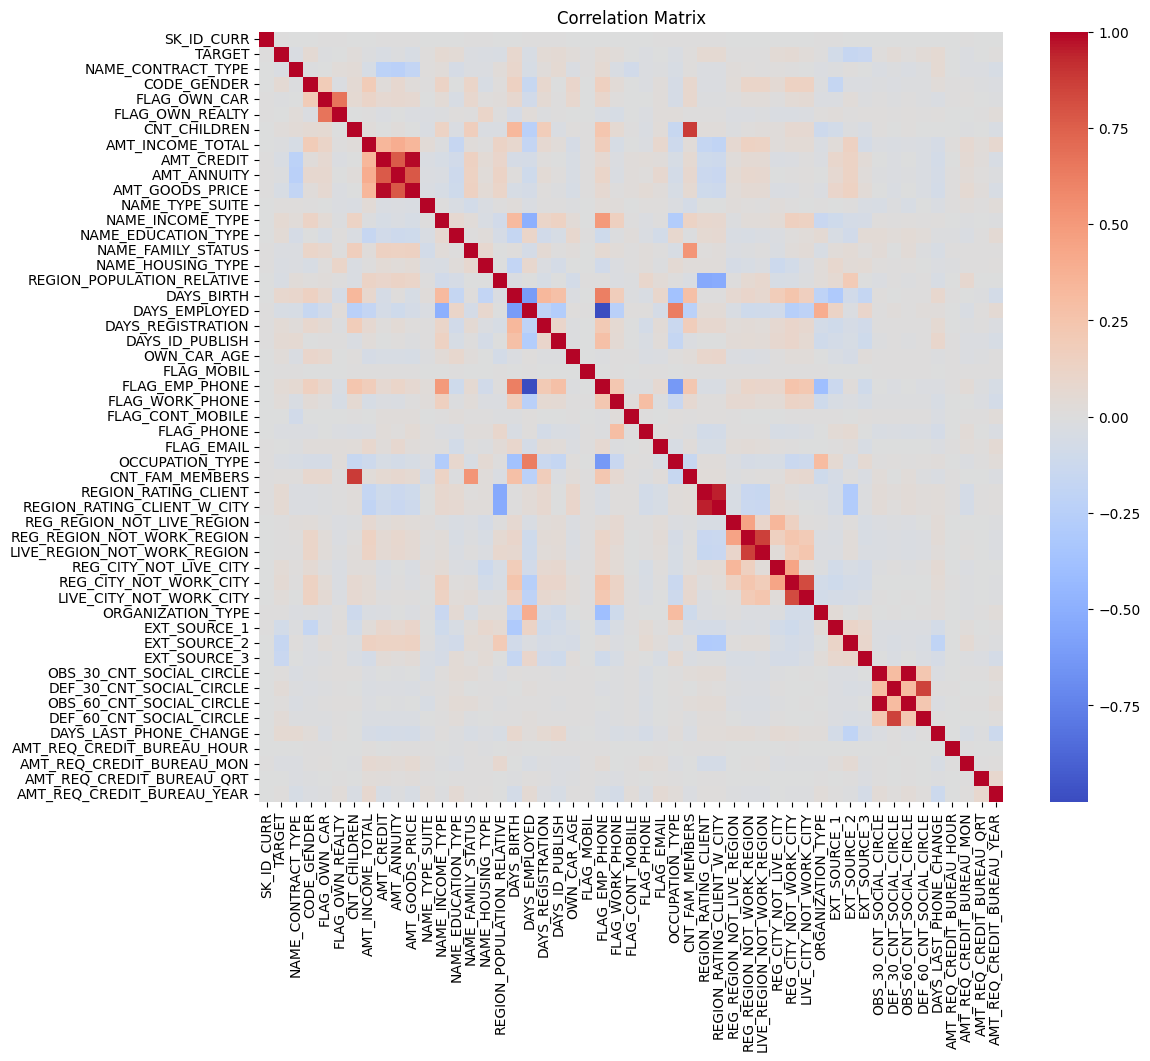

TARGET                         1.000000
EXT_SOURCE_2                   0.162383
EXT_SOURCE_3                   0.142190
EXT_SOURCE_1                   0.081994
DAYS_BIRTH                     0.079541
REGION_RATING_CLIENT_W_CITY    0.061132
REGION_RATING_CLIENT           0.058984
NAME_INCOME_TYPE               0.058168
DAYS_LAST_PHONE_CHANGE         0.055195
CODE_GENDER                    0.054420
DAYS_ID_PUBLISH                0.052567
REG_CITY_NOT_WORK_CITY         0.049438
FLAG_EMP_PHONE                 0.045646
DAYS_EMPLOYED                  0.044592
REG_CITY_NOT_LIVE_CITY         0.043829
NAME_EDUCATION_TYPE            0.042734
AMT_GOODS_PRICE                0.041887
DAYS_REGISTRATION              0.041669
REGION_POPULATION_RELATIVE     0.038259
DEF_60_CNT_SOCIAL_CIRCLE       0.033185
DEF_30_CNT_SOCIAL_CIRCLE       0.032940
AMT_CREDIT                     0.032727
LIVE_CITY_NOT_WORK_CITY        0.030409
NAME_CONTRACT_TYPE             0.029946
NAME_HOUSING_TYPE              0.029620


In [23]:
# 必要なライブラリのインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.feature_selection import SelectFromModel

# データの読み込み
INPUT_DIR = "./input/"

train = pd.read_csv(INPUT_DIR + "train.csv")
test = pd.read_csv(INPUT_DIR + "test.csv")
sample_sub = pd.read_csv(INPUT_DIR + "sample_submission.csv")

# データの基本情報
print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")

# 欠損値の確認
missing_train = train.isnull().sum().sort_values(ascending=False)
missing_test = test.isnull().sum().sort_values(ascending=False)

print("Train Missing Values:\n", missing_train[missing_train > 0])
print("\nTest Missing Values:\n", missing_test[missing_test > 0])

# データのコピー
train_processed = train.copy()
test_processed = test.copy()

# 数値型特徴量の補完（中央値）
num_cols = train_processed.select_dtypes(include=['float64', 'int64']).columns.tolist()
num_cols.remove('TARGET')  # 目的変数は除外

for col in num_cols:
    median = train_processed[col].median()
    train_processed[col].fillna(median, inplace=True)
    test_processed[col].fillna(median, inplace=True)

# カテゴリ型特徴量の補完
cat_cols = train_processed.select_dtypes(include=['object']).columns.tolist()
for col in cat_cols:
    train_processed[col].fillna('Missing', inplace=True)
    test_processed[col].fillna('Missing', inplace=True)

# OWN_CAR_AGEの外れ値処理（60以上を欠損値として扱い中央値で補完）
if train_processed['OWN_CAR_AGE'].max() >= 60:
    train_processed.loc[train_processed["OWN_CAR_AGE"] >= 60, "OWN_CAR_AGE"] = np.nan
    test_processed.loc[test_processed["OWN_CAR_AGE"] >= 60, "OWN_CAR_AGE"] = np.nan
    median_car_age = train_processed['OWN_CAR_AGE'].median()
    train_processed['OWN_CAR_AGE'].fillna(median_car_age, inplace=True)
    test_processed['OWN_CAR_AGE'].fillna(median_car_age, inplace=True)

# 再度欠損値を確認
print("After imputation, missing values in train:", train_processed.isnull().sum().max())

# カテゴリ型特徴量のエンコード
# バイナリカテゴリ型特徴量のエンコード
binary_cols = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']
le = LabelEncoder()
for col in binary_cols:
    train_processed[col] = le.fit_transform(train_processed[col])
    test_processed[col] = le.transform(test_processed[col])

# その他のカテゴリ型特徴量のカウントエンコーディング
other_cat_cols = [col for col in cat_cols if col not in binary_cols]
for col in other_cat_cols:
    freq_encoding = train_processed[col].value_counts()
    train_processed[col] = train_processed[col].map(freq_encoding)
    test_processed[col] = test_processed[col].map(freq_encoding)
    # 欠損値が発生した場合は0で埋める
    train_processed[col].fillna(0, inplace=True)
    test_processed[col].fillna(0, inplace=True)

# 外れ値の処理（例: AMT_INCOME_TOTAL）
Q1 = train_processed['AMT_INCOME_TOTAL'].quantile(0.25)
Q3 = train_processed['AMT_INCOME_TOTAL'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 外れ値を中央値で補完
train_processed['AMT_INCOME_TOTAL'] = np.where(
    (train_processed['AMT_INCOME_TOTAL'] < lower_bound) | (train_processed['AMT_INCOME_TOTAL'] > upper_bound),
    train_processed['AMT_INCOME_TOTAL'].median(),
    train_processed['AMT_INCOME_TOTAL']
)

test_processed['AMT_INCOME_TOTAL'] = np.where(
    (test_processed['AMT_INCOME_TOTAL'] < lower_bound) | (test_processed['AMT_INCOME_TOTAL'] > upper_bound),
    test_processed['AMT_INCOME_TOTAL'].median(),
    test_processed['AMT_INCOME_TOTAL']
)

# 相関係数の確認
corr_matrix = train_processed.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# ターゲットとの相関が高い特徴量を選択
target_corr = corr_matrix['TARGET'].abs().sort_values(ascending=False)
print(target_corr)

# 相関が0.05以上の特徴量を選択（閾値は調整可能）
selected_features_corr = target_corr[target_corr > 0.05].index.tolist()

# 'TARGET'と'SK_ID_CURR'を除外（存在する場合のみ）
for col in ['TARGET', 'SK_ID_CURR']:
    if col in selected_features_corr:
        selected_features_corr.remove(col)

print(f"Selected Features based on Correlation ({len(selected_features_corr)}): {selected_features_corr}")

# モデルベースの特徴量選択（RandomForest）
X_all = train_processed.drop(['SK_ID_CURR', 'TARGET'], axis=1)
y_all = train_processed['TARGET']

rf = RandomForestClassifier(random_state=42, n_estimators=100)
rf.fit(X_all, y_all)

# 特徴量重要度の取得
importances = rf.feature_importances_
feature_importances_rf = pd.Series(importances, index=X_all.columns).sort_values(ascending=False)
print(feature_importances_rf)

# 重要度が上位20の特徴量を選択
selected_features_rf = feature_importances_rf[:20].index.tolist()
print(f"Selected Features based on RandomForest ({len(selected_features_rf)}): {selected_features_rf}")

# 相関係数とRandomForestで選択した特徴量の統合
selected_features = list(set(selected_features_corr) | set(selected_features_rf))
print(f"Final Selected Features ({len(selected_features)}): {selected_features}")

# 特徴量エンジニアリング
# 相互作用特徴量の追加
train_processed['EXT_SOURCE_2_EXT_SOURCE_3'] = train_processed['EXT_SOURCE_2'] * train_processed['EXT_SOURCE_3']
test_processed['EXT_SOURCE_2_EXT_SOURCE_3'] = test_processed['EXT_SOURCE_2'] * test_processed['EXT_SOURCE_3']

# 年齢の計算（DAYS_BIRTHから）
train_processed['AGE'] = -train_processed['DAYS_BIRTH'] / 365
test_processed['AGE'] = -test_processed['DAYS_BIRTH'] / 365

# DAYS_ID_PUBLISHを年数に変換
train_processed['DAYS_ID_PUBLISH_YEAR'] = train_processed['DAYS_ID_PUBLISH'] / 365
test_processed['DAYS_ID_PUBLISH_YEAR'] = test_processed['DAYS_ID_PUBLISH'] / 365

# DAYS_LAST_PHONE_CHANGEを年数に変換
train_processed['DAYS_LAST_PHONE_CHANGE_YEAR'] = train_processed['DAYS_LAST_PHONE_CHANGE'] / 365
test_processed['DAYS_LAST_PHONE_CHANGE_YEAR'] = test_processed['DAYS_LAST_PHONE_CHANGE'] / 365

# 新しい特徴量を選択リストに追加
new_features = ['EXT_SOURCE_2_EXT_SOURCE_3', 'AGE', 'DAYS_ID_PUBLISH_YEAR', 'DAYS_LAST_PHONE_CHANGE_YEAR']
selected_features += new_features

# 再度重複を除去
selected_features = list(set(selected_features))
print(f"Selected Features after Engineering ({len(selected_features)}): {selected_features}")

# データのスケーリング
scaler = StandardScaler()
train_processed[selected_features] = scaler.fit_transform(train_processed[selected_features])
test_processed[selected_features] = scaler.transform(test_processed[selected_features])

# モデルの訓練と評価
X = train_processed[selected_features]
y = train_processed['TARGET']
X_test_final = test_processed[selected_features]

# 訓練データと検証データに分割
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# モデルの初期化
models = {
    'LogisticRegression': LogisticRegression(random_state=42, max_iter=1000),
    'MLPClassifier': MLPClassifier(random_state=42, max_iter=500),
    'RandomForest': RandomForestClassifier(random_state=42, n_estimators=100),
    'XGBoost': XGBClassifier(
        random_state=42,
        n_estimators=50,
        learning_rate=0.1,
        max_depth=5,
        use_label_encoder=False,
        eval_metric='auc'
    ),
    'LightGBM': LGBMClassifier(
        random_state=42,
        n_estimators=100,
        learning_rate=0.1,
        max_depth=7
    )
}

# 各モデルのトレーニングと評価
model_performance = {}

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)

    # 訓練データの予測
    y_train_pred = model.predict_proba(X_train)[:, 1]
    # 検証データの予測
    y_valid_pred = model.predict_proba(X_valid)[:, 1]

    # AUCスコアの計算
    train_auc = roc_auc_score(y_train, y_train_pred)
    valid_auc = roc_auc_score(y_valid, y_valid_pred)

    model_performance[name] = {
        'Train AUC': train_auc,
        'Valid AUC': valid_auc
    }
    print(f"{name} - Train AUC: {train_auc:.4f}, Valid AUC: {valid_auc:.4f}\n")

# モデルの性能比較
performance_df = pd.DataFrame(model_performance).T
print(performance_df)


In [24]:
# 低重要度特徴量の除去
low_importance_features = ['NAME_INCOME_TYPE', 'REGION_RATING_CLIENT_W_CITY', 'REGION_RATING_CLIENT', 'CODE_GENDER']
selected_features = [feat for feat in selected_features if feat not in low_importance_features]
print(f"Selected Features after Removing Low Importance ({len(selected_features)}): {selected_features}")


Selected Features after Removing Low Importance (24): ['OWN_CAR_AGE', 'DAYS_BIRTH', 'AMT_CREDIT', 'REGION_POPULATION_RELATIVE', 'OCCUPATION_TYPE', 'DAYS_LAST_PHONE_CHANGE', 'DAYS_EMPLOYED', 'AMT_INCOME_TOTAL', 'AMT_GOODS_PRICE', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DAYS_REGISTRATION', 'EXT_SOURCE_2_EXT_SOURCE_3', 'EXT_SOURCE_1', 'AGE', 'EXT_SOURCE_2', 'DAYS_ID_PUBLISH', 'EXT_SOURCE_3', 'ORGANIZATION_TYPE', 'DAYS_LAST_PHONE_CHANGE_YEAR', 'CNT_FAM_MEMBERS', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DAYS_ID_PUBLISH_YEAR', 'AMT_ANNUITY']


In [25]:
# 特徴量エンジニアリングの追加

# 1. 相互作用特徴量の追加
train_processed['EXT_SOURCE_2_EXT_SOURCE_3'] = train_processed['EXT_SOURCE_2'] * train_processed['EXT_SOURCE_3']
test_processed['EXT_SOURCE_2_EXT_SOURCE_3'] = test_processed['EXT_SOURCE_2'] * test_processed['EXT_SOURCE_3']

# 特徴量リストに追加
selected_features.append('EXT_SOURCE_2_EXT_SOURCE_3')

# 2. 年齢の計算（DAYS_BIRTHから）
train_processed['AGE'] = -train_processed['DAYS_BIRTH'] / 365
test_processed['AGE'] = -test_processed['DAYS_BIRTH'] / 365

# 3. DAYS_ID_PUBLISHを年数に変換
train_processed['DAYS_ID_PUBLISH_YEAR'] = train_processed['DAYS_ID_PUBLISH'] / 365
test_processed['DAYS_ID_PUBLISH_YEAR'] = test_processed['DAYS_ID_PUBLISH'] / 365

# 4. DAYS_LAST_PHONE_CHANGEを年数に変換
train_processed['DAYS_LAST_PHONE_CHANGE_YEAR'] = train_processed['DAYS_LAST_PHONE_CHANGE'] / 365
test_processed['DAYS_LAST_PHONE_CHANGE_YEAR'] = test_processed['DAYS_LAST_PHONE_CHANGE'] / 365

# 5. 最近1年以内に電話変更があったかを示すバイナリ特徴量
train_processed['PHONE_CHANGE_RECENT'] = (train_processed['DAYS_LAST_PHONE_CHANGE_YEAR'] <= 1).astype(int)
test_processed['PHONE_CHANGE_RECENT'] = (test_processed['DAYS_LAST_PHONE_CHANGE_YEAR'] <= 1).astype(int)

# 6. 年齢グループの作成
train_processed['AGE_GROUP'] = pd.cut(train_processed['AGE'], bins=[0, 25, 35, 45, 55, 65, 100], labels=False)
test_processed['AGE_GROUP'] = pd.cut(test_processed['AGE'], bins=[0, 25, 35, 45, 55, 65, 100], labels=False)

# 7. 年齢グループをスケーリング
train_processed['AGE_GROUP'] = scaler.fit_transform(train_processed[['AGE_GROUP']])
test_processed['AGE_GROUP'] = scaler.transform(test_processed[['AGE_GROUP']])

# 特徴量リストに追加
new_features = [
    'EXT_SOURCE_2_EXT_SOURCE_3',
    'AGE',
    'DAYS_ID_PUBLISH_YEAR',
    'DAYS_LAST_PHONE_CHANGE_YEAR',
    'PHONE_CHANGE_RECENT',
    'AGE_GROUP'
]
selected_features += new_features

# 再度重複を除去
selected_features = list(set(selected_features))
print(f"Selected Features after Engineering ({len(selected_features)}): {selected_features}")


Selected Features after Engineering (26): ['OWN_CAR_AGE', 'DAYS_BIRTH', 'AMT_CREDIT', 'REGION_POPULATION_RELATIVE', 'OCCUPATION_TYPE', 'DAYS_LAST_PHONE_CHANGE', 'DAYS_EMPLOYED', 'AMT_INCOME_TOTAL', 'AMT_GOODS_PRICE', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DAYS_REGISTRATION', 'EXT_SOURCE_2_EXT_SOURCE_3', 'EXT_SOURCE_1', 'AGE_GROUP', 'AGE', 'EXT_SOURCE_2', 'DAYS_ID_PUBLISH', 'EXT_SOURCE_3', 'PHONE_CHANGE_RECENT', 'DAYS_LAST_PHONE_CHANGE_YEAR', 'ORGANIZATION_TYPE', 'CNT_FAM_MEMBERS', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DAYS_ID_PUBLISH_YEAR', 'AMT_ANNUITY']


In [26]:
# 特徴量のスケーリング（既に一部スケーリング済み）
# 必要に応じて再スケーリング
scaler = StandardScaler()
train_processed[selected_features] = scaler.fit_transform(train_processed[selected_features])
test_processed[selected_features] = scaler.transform(test_processed[selected_features])


In [28]:
# 1. ライブラリのインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

warnings.filterwarnings('ignore')

# 2. データの読み込み
INPUT_DIR = "./input/"  # データが格納されているディレクトリパスに変更してください

train = pd.read_csv(INPUT_DIR + "train.csv")
test = pd.read_csv(INPUT_DIR + "test.csv")
sample_sub = pd.read_csv(INPUT_DIR + "sample_submission.csv")

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")

# 3. データの前処理

# 3.1. データのコピー
train_processed = train.copy()
test_processed = test.copy()

# 3.2. 数値型特徴量の補完（中央値）
num_cols = train_processed.select_dtypes(include=['float64', 'int64']).columns.tolist()
num_cols.remove('TARGET')  # 目的変数は除外

imputer = SimpleImputer(strategy='median')
train_processed[num_cols] = imputer.fit_transform(train_processed[num_cols])
test_processed[num_cols] = imputer.transform(test_processed[num_cols])

# 3.3. カテゴリ型特徴量の補完
cat_cols = train_processed.select_dtypes(include=['object']).columns.tolist()
for col in cat_cols:
    train_processed[col].fillna('Missing', inplace=True)
    test_processed[col].fillna('Missing', inplace=True)

# 3.4. OWN_CAR_AGEの外れ値処理（60以上を欠損値として扱い中央値で補完）
if 'OWN_CAR_AGE' in train_processed.columns:
    if train_processed['OWN_CAR_AGE'].max() >= 60:
        train_processed.loc[train_processed["OWN_CAR_AGE"] >= 60, "OWN_CAR_AGE"] = np.nan
        test_processed.loc[test_processed["OWN_CAR_AGE"] >= 60, "OWN_CAR_AGE"] = np.nan
        median_car_age = train_processed['OWN_CAR_AGE'].median()
        train_processed['OWN_CAR_AGE'].fillna(median_car_age, inplace=True)
        test_processed['OWN_CAR_AGE'].fillna(median_car_age, inplace=True)

# 3.5. カテゴリ型特徴量のエンコード

# 3.5.1. バイナリカテゴリ型特徴量のエンコード
binary_cols = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']
le = LabelEncoder()
for col in binary_cols:
    if col in train_processed.columns:
        train_processed[col] = le.fit_transform(train_processed[col])
        test_processed[col] = le.transform(test_processed[col])

# 3.5.2. その他のカテゴリ型特徴量のカウントエンコーディング
other_cat_cols = [col for col in cat_cols if col not in binary_cols]
for col in other_cat_cols:
    freq_encoding = train_processed[col].value_counts()
    train_processed[col] = train_processed[col].map(freq_encoding)
    test_processed[col] = test_processed[col].map(freq_encoding)
    train_processed[col].fillna(0, inplace=True)
    test_processed[col].fillna(0, inplace=True)

# 3.6. 外れ値の処理（例: AMT_INCOME_TOTAL）
if 'AMT_INCOME_TOTAL' in train_processed.columns:
    Q1 = train_processed['AMT_INCOME_TOTAL'].quantile(0.25)
    Q3 = train_processed['AMT_INCOME_TOTAL'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # 外れ値を中央値で補完
    train_processed['AMT_INCOME_TOTAL'] = np.where(
        (train_processed['AMT_INCOME_TOTAL'] < lower_bound) | (train_processed['AMT_INCOME_TOTAL'] > upper_bound),
        train_processed['AMT_INCOME_TOTAL'].median(),
        train_processed['AMT_INCOME_TOTAL']
    )

    test_processed['AMT_INCOME_TOTAL'] = np.where(
        (test_processed['AMT_INCOME_TOTAL'] < lower_bound) | (test_processed['AMT_INCOME_TOTAL'] > upper_bound),
        test_processed['AMT_INCOME_TOTAL'].median(),
        test_processed['AMT_INCOME_TOTAL']
    )

# 4. 特徴量選択

# 4.1. 特徴量重要度の計算（RandomForestを使用）
X_all = train_processed.drop(['SK_ID_CURR', 'TARGET'], axis=1)
y_all = train_processed['TARGET']

rf = RandomForestClassifier(random_state=42, n_estimators=100)
rf.fit(X_all, y_all)

importances_rf = rf.feature_importances_
feature_importances_rf = pd.Series(importances_rf, index=X_all.columns).sort_values(ascending=False)

# 4.2. 重要度が上位の特徴量を選択（ここでは20を例として）
selected_features_rf = feature_importances_rf[:20].index.tolist()

# 4.3. 相関係数に基づく特徴量選択
corr_matrix = train_processed.corr()
target_corr = corr_matrix['TARGET'].abs().sort_values(ascending=False)
selected_features_corr = target_corr[target_corr > 0.05].index.tolist()
selected_features_corr.remove('TARGET')  # 目的変数は除外

# 4.4. 最終的な特徴量リストの作成
selected_features = list(set(selected_features_rf) | set(selected_features_corr))
print(f"Selected Features ({len(selected_features)}): {selected_features}")

# 5. 特徴量エンジニアリング

# 5.1. 相互作用特徴量の追加
train_processed['EXT_SOURCE_2_EXT_SOURCE_3'] = train_processed['EXT_SOURCE_2'] * train_processed['EXT_SOURCE_3']
test_processed['EXT_SOURCE_2_EXT_SOURCE_3'] = test_processed['EXT_SOURCE_2'] * test_processed['EXT_SOURCE_3']
selected_features.append('EXT_SOURCE_2_EXT_SOURCE_3')

# 5.2. 年齢の計算（DAYS_BIRTHから）
train_processed['AGE'] = -train_processed['DAYS_BIRTH'] / 365
test_processed['AGE'] = -test_processed['DAYS_BIRTH'] / 365
selected_features.append('AGE')

# 5.3. DAYS_ID_PUBLISHを年数に変換
train_processed['DAYS_ID_PUBLISH_YEAR'] = train_processed['DAYS_ID_PUBLISH'] / 365
test_processed['DAYS_ID_PUBLISH_YEAR'] = test_processed['DAYS_ID_PUBLISH'] / 365
selected_features.append('DAYS_ID_PUBLISH_YEAR')

# 5.4. DAYS_LAST_PHONE_CHANGEを年数に変換
train_processed['DAYS_LAST_PHONE_CHANGE_YEAR'] = train_processed['DAYS_LAST_PHONE_CHANGE'] / 365
test_processed['DAYS_LAST_PHONE_CHANGE_YEAR'] = test_processed['DAYS_LAST_PHONE_CHANGE'] / 365
selected_features.append('DAYS_LAST_PHONE_CHANGE_YEAR')

# 5.5. 最近1年以内に電話変更があったかを示すバイナリ特徴量
train_processed['PHONE_CHANGE_RECENT'] = (train_processed['DAYS_LAST_PHONE_CHANGE_YEAR'] <= 1).astype(int)
test_processed['PHONE_CHANGE_RECENT'] = (test_processed['DAYS_LAST_PHONE_CHANGE_YEAR'] <= 1).astype(int)
selected_features.append('PHONE_CHANGE_RECENT')

# 5.6. 年齢グループの作成
train_processed['AGE_GROUP'] = pd.cut(train_processed['AGE'], bins=[0, 25, 35, 45, 55, 65, 100], labels=False)
test_processed['AGE_GROUP'] = pd.cut(test_processed['AGE'], bins=[0, 25, 35, 45, 55, 65, 100], labels=False)
selected_features.append('AGE_GROUP')

# 5.7. EXT_SOURCE_1 と EXT_SOURCE_2 の相互作用
train_processed['EXT_SOURCE_1_EXT_SOURCE_2'] = train_processed['EXT_SOURCE_1'] * train_processed['EXT_SOURCE_2']
test_processed['EXT_SOURCE_1_EXT_SOURCE_2'] = test_processed['EXT_SOURCE_1'] * test_processed['EXT_SOURCE_2']
selected_features.append('EXT_SOURCE_1_EXT_SOURCE_2')

# 5.8. AMT_INCOME_TOTAL が中央値以上かどうかのバイナリ特徴量
income_median = train_processed['AMT_INCOME_TOTAL'].median()
train_processed['INCOME_ABOVE_MEDIAN'] = (train_processed['AMT_INCOME_TOTAL'] >= income_median).astype(int)
test_processed['INCOME_ABOVE_MEDIAN'] = (test_processed['AMT_INCOME_TOTAL'] >= income_median).astype(int)
selected_features.append('INCOME_ABOVE_MEDIAN')

# 5.9. 地域ごとの AMT_INCOME_TOTAL の平均
region_income_mean = train_processed.groupby('REGION_RATING_CLIENT_W_CITY')['AMT_INCOME_TOTAL'].mean()
train_processed['REGION_INCOME_MEAN'] = train_processed['REGION_RATING_CLIENT_W_CITY'].map(region_income_mean)
test_processed['REGION_INCOME_MEAN'] = test_processed['REGION_RATING_CLIENT_W_CITY'].map(region_income_mean)

# 欠損値が発生した場合は全体の平均で補完
train_processed['REGION_INCOME_MEAN'].fillna(train_processed['AMT_INCOME_TOTAL'].mean(), inplace=True)
test_processed['REGION_INCOME_MEAN'].fillna(test_processed['AMT_INCOME_TOTAL'].mean(), inplace=True)
selected_features.append('REGION_INCOME_MEAN')

# 6. データのスケーリング
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

train_processed[selected_features] = pipeline.fit_transform(train_processed[selected_features])
test_processed[selected_features] = pipeline.transform(test_processed[selected_features])

# 7. 特徴量選択後の欠損値再確認
missing_after_final = train_processed[selected_features].isnull().sum()
missing_after_final = missing_after_final[missing_after_final > 0]
print("Missing values in selected features after final processing:")
print(missing_after_final)

# もしまだ欠損値が存在する場合、再度補完を行います
if not missing_after_final.empty:
    train_processed[selected_features] = imputer.fit_transform(train_processed[selected_features])
    test_processed[selected_features] = imputer.transform(test_processed[selected_features])

# 8. 目的変数と説明変数の分割
X = train_processed[selected_features]
y = train_processed['TARGET']
X_test_final = test_processed[selected_features]

# 9. 訓練データと検証データに分割
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# 10. モデルの初期化
models = {
    'LogisticRegression': LogisticRegression(random_state=42, max_iter=1000),
    'MLPClassifier': MLPClassifier(random_state=42, max_iter=500),
    'RandomForest': RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10, min_samples_split=10),
    'XGBoost': XGBClassifier(
        random_state=42,
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        use_label_encoder=False,
        eval_metric='auc'
    ),
    'LightGBM': LGBMClassifier(
        random_state=42,
        n_estimators=100,
        learning_rate=0.1,
        max_depth=7
    )
}

# 11. 各モデルのトレーニングと評価
model_performance = {}

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)

    # 訓練データの予測
    y_train_pred = model.predict_proba(X_train)[:, 1]
    # 検証データの予測
    y_valid_pred = model.predict_proba(X_valid)[:, 1]

    # AUCスコアの計算
    train_auc = roc_auc_score(y_train, y_train_pred)
    valid_auc = roc_auc_score(y_valid, y_valid_pred)

    model_performance[name] = {
        'Train AUC': train_auc,
        'Valid AUC': valid_auc
    }
    print(f"{name} - Train AUC: {train_auc:.4f}, Valid AUC: {valid_auc:.4f}\n")

# モデルの性能比較
performance_df = pd.DataFrame(model_performance).T
print("Model Performance:")
print(performance_df)

# 12. アンサンブルモデルの構築（Voting Classifier）
voting_clf = VotingClassifier(
    estimators=[
        ('lr', models['LogisticRegression']),
        ('mlp', models['MLPClassifier']),
        ('rf', models['RandomForest']),
        ('xgb', models['XGBoost']),
        ('lgbm', models['LightGBM'])
    ],
    voting='soft'  # ソフト投票
)

print("Training Voting Classifier...")
voting_clf.fit(X_train, y_train)

# アンサンブルモデルの予測
y_train_pred_vc = voting_clf.predict_proba(X_train)[:, 1]
y_valid_pred_vc = voting_clf.predict_proba(X_valid)[:, 1]

# AUCスコアの計算
train_auc_vc = roc_auc_score(y_train, y_train_pred_vc)
valid_auc_vc = roc_auc_score(y_valid, y_valid_pred_vc)

print(f"VotingClassifier - Train AUC: {train_auc_vc:.4f}, Valid AUC: {valid_auc_vc:.4f}")

# 13. 最終モデルによる予測と提出ファイルの作成

# 最適なモデルの選択（ここではVotingClassifierを使用）
final_model = voting_clf

# 全データで再トレーニング
final_model.fit(X, y)

# テストデータに対する予測
test_pred = final_model.predict_proba(X_test_final)[:, 1]

# 提出用ファイルの作成
sample_sub['TARGET'] = test_pred
sample_sub.to_csv('submission_final.csv', index=False)
print("submission_final.csv が作成されました。")

# 14. 特徴量重要度の確認

# RandomForestの特徴量重要度
rf_importances = pd.Series(models['RandomForest'].feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nRandomForest Feature Importances:")
print(rf_importances.to_frame('Importance').reset_index().rename(columns={'index': 'Feature'}))

# XGBoostの特徴量重要度
xgb_importances = pd.Series(models['XGBoost'].feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nXGBoost Feature Importances:")
print(xgb_importances.to_frame('Importance').reset_index().rename(columns={'index': 'Feature'}))

# LightGBMの特徴量重要度
lgbm_importances = pd.Series(models['LightGBM'].feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nLightGBM Feature Importances:")
print(lgbm_importances.to_frame('Importance').reset_index().rename(columns={'index': 'Feature'}))

# 15. クロスバリデーションの導入（例としてLightGBM）
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

lightgbm = LGBMClassifier(random_state=42, n_estimators=300, learning_rate=0.1, max_depth=7)
cv_scores = cross_val_score(lightgbm, X, y, cv=cv, scoring='roc_auc', n_jobs=-1)
print(f"\nLightGBM Cross-Validation AUC Scores: {cv_scores}")
print(f"LightGBM Mean CV AUC: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# 16. スタッキングモデルの構築
estimators = [
    ('rf', models['RandomForest']),
    ('xgb', models['XGBoost']),
    ('lgbm', models['LightGBM'])
]

stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(),
    cv=5,
    n_jobs=-1
)

print("\nTraining Stacking Classifier...")
stacking_clf.fit(X_train, y_train)

# スタッキングモデルの予測
y_valid_pred_stack = stacking_clf.predict_proba(X_valid)[:, 1]

# AUCスコアの計算
valid_auc_stack = roc_auc_score(y_valid, y_valid_pred_stack)
print(f"StackingClassifier - Valid AUC: {valid_auc_stack:.4f}")

# 17. 最終モデル（スタッキングモデル）による予測と提出ファイルの作成
final_model_stack = stacking_clf

# 全データで再トレーニング
final_model_stack.fit(X, y)

# テストデータに対する予測
test_pred_stack = final_model_stack.predict_proba(X_test_final)[:, 1]

# 提出用ファイルの作成
sample_sub['TARGET'] = test_pred_stack
sample_sub.to_csv('submission_final_stack.csv', index=False)
print("submission_final_stack.csv が作成されました。")



Train shape: (171202, 51)
Test shape: (61500, 50)
Selected Features (24): ['REGION_RATING_CLIENT', 'OWN_CAR_AGE', 'DAYS_BIRTH', 'EXT_SOURCE_1', 'NAME_INCOME_TYPE', 'AMT_CREDIT', 'REGION_POPULATION_RELATIVE', 'OCCUPATION_TYPE', 'EXT_SOURCE_2', 'DAYS_ID_PUBLISH', 'DAYS_LAST_PHONE_CHANGE', 'EXT_SOURCE_3', 'ORGANIZATION_TYPE', 'DAYS_EMPLOYED', 'AMT_INCOME_TOTAL', 'AMT_GOODS_PRICE', 'REGION_RATING_CLIENT_W_CITY', 'OBS_30_CNT_SOCIAL_CIRCLE', 'CNT_FAM_MEMBERS', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DAYS_REGISTRATION', 'CODE_GENDER', 'AMT_ANNUITY']
Missing values in selected features after final processing:
Series([], dtype: int64)
Training LogisticRegression...
LogisticRegression - Train AUC: 0.7278, Valid AUC: 0.7248

Training MLPClassifier...
MLPClassifier - Train AUC: 0.7928, Valid AUC: 0.7004

Training RandomForest...
RandomForest - Train AUC: 0.8105, Valid AUC: 0.7271

Training XGBoost...
XGBoost - Train AUC: 0.7928, Valid AUC: 0.7454

Training LightGBM...
[LightGBM]

In [29]:
# 1. ライブラリのインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

warnings.filterwarnings('ignore')

# 2. データの読み込み
INPUT_DIR = "./input/"  # データが格納されているディレクトリパスに変更してください

train = pd.read_csv(INPUT_DIR + "train.csv")
test = pd.read_csv(INPUT_DIR + "test.csv")
sample_sub = pd.read_csv(INPUT_DIR + "sample_submission.csv")

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")

# 3. データの前処理

# 3.1. データのコピー
train_processed = train.copy()
test_processed = test.copy()

# 3.2. 数値型特徴量の補完（中央値）
num_cols = train_processed.select_dtypes(include=['float64', 'int64']).columns.tolist()
num_cols.remove('TARGET')  # 目的変数は除外

imputer = SimpleImputer(strategy='median')
train_processed[num_cols] = imputer.fit_transform(train_processed[num_cols])
test_processed[num_cols] = imputer.transform(test_processed[num_cols])

# 3.3. カテゴリ型特徴量の補完
cat_cols = train_processed.select_dtypes(include=['object']).columns.tolist()
for col in cat_cols:
    train_processed[col].fillna('Missing', inplace=True)
    test_processed[col].fillna('Missing', inplace=True)

# 3.4. OWN_CAR_AGEの外れ値処理（60以上を欠損値として扱い中央値で補完）
if 'OWN_CAR_AGE' in train_processed.columns:
    if train_processed['OWN_CAR_AGE'].max() >= 60:
        train_processed.loc[train_processed["OWN_CAR_AGE"] >= 60, "OWN_CAR_AGE"] = np.nan
        test_processed.loc[test_processed["OWN_CAR_AGE"] >= 60, "OWN_CAR_AGE"] = np.nan
        median_car_age = train_processed['OWN_CAR_AGE'].median()
        train_processed['OWN_CAR_AGE'].fillna(median_car_age, inplace=True)
        test_processed['OWN_CAR_AGE'].fillna(median_car_age, inplace=True)

# 3.5. カテゴリ型特徴量のエンコード

# 3.5.1. バイナリカテゴリ型特徴量のエンコード
binary_cols = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']
le = LabelEncoder()
for col in binary_cols:
    if col in train_processed.columns:
        train_processed[col] = le.fit_transform(train_processed[col])
        test_processed[col] = le.transform(test_processed[col])

# 3.5.2. その他のカテゴリ型特徴量のカウントエンコーディング
other_cat_cols = [col for col in cat_cols if col not in binary_cols]
for col in other_cat_cols:
    freq_encoding = train_processed[col].value_counts()
    train_processed[col] = train_processed[col].map(freq_encoding)
    test_processed[col] = test_processed[col].map(freq_encoding)
    train_processed[col].fillna(0, inplace=True)
    test_processed[col].fillna(0, inplace=True)

# 3.6. 外れ値の処理（例: AMT_INCOME_TOTAL）
if 'AMT_INCOME_TOTAL' in train_processed.columns:
    Q1 = train_processed['AMT_INCOME_TOTAL'].quantile(0.25)
    Q3 = train_processed['AMT_INCOME_TOTAL'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # 外れ値を中央値で補完
    train_processed['AMT_INCOME_TOTAL'] = np.where(
        (train_processed['AMT_INCOME_TOTAL'] < lower_bound) | (train_processed['AMT_INCOME_TOTAL'] > upper_bound),
        train_processed['AMT_INCOME_TOTAL'].median(),
        train_processed['AMT_INCOME_TOTAL']
    )

    test_processed['AMT_INCOME_TOTAL'] = np.where(
        (test_processed['AMT_INCOME_TOTAL'] < lower_bound) | (test_processed['AMT_INCOME_TOTAL'] > upper_bound),
        test_processed['AMT_INCOME_TOTAL'].median(),
        test_processed['AMT_INCOME_TOTAL']
    )

# 4. 特徴量選択

# 4.1. 特徴量重要度の計算（RandomForestを使用）
X_all = train_processed.drop(['SK_ID_CURR', 'TARGET'], axis=1)
y_all = train_processed['TARGET']

rf_initial = RandomForestClassifier(random_state=42, n_estimators=100)
rf_initial.fit(X_all, y_all)

importances_rf = rf_initial.feature_importances_
feature_importances_rf = pd.Series(importances_rf, index=X_all.columns).sort_values(ascending=False)

# 4.2. 重要度が上位の特徴量を選択（ここでは20を例として）
selected_features_rf = feature_importances_rf[:20].index.tolist()

# 4.3. 相関係数に基づく特徴量選択
corr_matrix = train_processed.corr()
target_corr = corr_matrix['TARGET'].abs().sort_values(ascending=False)
selected_features_corr = target_corr[target_corr > 0.05].index.tolist()
selected_features_corr.remove('TARGET')  # 目的変数は除外

# 4.4. 最終的な特徴量リストの作成
selected_features = list(set(selected_features_rf) | set(selected_features_corr))
print(f"Selected Features ({len(selected_features)}): {selected_features}")

# 5. 特徴量エンジニアリング

# 5.1. 相互作用特徴量の追加
train_processed['EXT_SOURCE_2_EXT_SOURCE_3'] = train_processed['EXT_SOURCE_2'] * train_processed['EXT_SOURCE_3']
test_processed['EXT_SOURCE_2_EXT_SOURCE_3'] = test_processed['EXT_SOURCE_2'] * test_processed['EXT_SOURCE_3']
selected_features.append('EXT_SOURCE_2_EXT_SOURCE_3')

# 5.2. 年齢の計算（DAYS_BIRTHから）
train_processed['AGE'] = -train_processed['DAYS_BIRTH'] / 365
test_processed['AGE'] = -test_processed['DAYS_BIRTH'] / 365
selected_features.append('AGE')

# 5.3. DAYS_ID_PUBLISHを年数に変換
train_processed['DAYS_ID_PUBLISH_YEAR'] = train_processed['DAYS_ID_PUBLISH'] / 365
test_processed['DAYS_ID_PUBLISH_YEAR'] = test_processed['DAYS_ID_PUBLISH'] / 365
selected_features.append('DAYS_ID_PUBLISH_YEAR')

# 5.4. DAYS_LAST_PHONE_CHANGEを年数に変換
train_processed['DAYS_LAST_PHONE_CHANGE_YEAR'] = train_processed['DAYS_LAST_PHONE_CHANGE'] / 365
test_processed['DAYS_LAST_PHONE_CHANGE_YEAR'] = test_processed['DAYS_LAST_PHONE_CHANGE'] / 365
selected_features.append('DAYS_LAST_PHONE_CHANGE_YEAR')

# 5.5. 最近1年以内に電話変更があったかを示すバイナリ特徴量
train_processed['PHONE_CHANGE_RECENT'] = (train_processed['DAYS_LAST_PHONE_CHANGE_YEAR'] <= 1).astype(int)
test_processed['PHONE_CHANGE_RECENT'] = (test_processed['DAYS_LAST_PHONE_CHANGE_YEAR'] <= 1).astype(int)
selected_features.append('PHONE_CHANGE_RECENT')

# 5.6. 年齢グループの作成
train_processed['AGE_GROUP'] = pd.cut(train_processed['AGE'], bins=[0, 25, 35, 45, 55, 65, 100], labels=False)
test_processed['AGE_GROUP'] = pd.cut(test_processed['AGE'], bins=[0, 25, 35, 45, 55, 65, 100], labels=False)
selected_features.append('AGE_GROUP')

# 5.7. EXT_SOURCE_1 と EXT_SOURCE_2 の相互作用
train_processed['EXT_SOURCE_1_EXT_SOURCE_2'] = train_processed['EXT_SOURCE_1'] * train_processed['EXT_SOURCE_2']
test_processed['EXT_SOURCE_1_EXT_SOURCE_2'] = test_processed['EXT_SOURCE_1'] * test_processed['EXT_SOURCE_2']
selected_features.append('EXT_SOURCE_1_EXT_SOURCE_2')

# 5.8. AMT_INCOME_TOTAL が中央値以上かどうかのバイナリ特徴量
income_median = train_processed['AMT_INCOME_TOTAL'].median()
train_processed['INCOME_ABOVE_MEDIAN'] = (train_processed['AMT_INCOME_TOTAL'] >= income_median).astype(int)
test_processed['INCOME_ABOVE_MEDIAN'] = (test_processed['AMT_INCOME_TOTAL'] >= income_median).astype(int)
selected_features.append('INCOME_ABOVE_MEDIAN')

# 5.9. 地域ごとの AMT_INCOME_TOTAL の平均
region_income_mean = train_processed.groupby('REGION_RATING_CLIENT_W_CITY')['AMT_INCOME_TOTAL'].mean()
train_processed['REGION_INCOME_MEAN'] = train_processed['REGION_RATING_CLIENT_W_CITY'].map(region_income_mean)
test_processed['REGION_INCOME_MEAN'] = test_processed['REGION_RATING_CLIENT_W_CITY'].map(region_income_mean)

# 欠損値が発生した場合は全体の平均で補完
train_processed['REGION_INCOME_MEAN'].fillna(train_processed['AMT_INCOME_TOTAL'].mean(), inplace=True)
test_processed['REGION_INCOME_MEAN'].fillna(test_processed['AMT_INCOME_TOTAL'].mean(), inplace=True)
selected_features.append('REGION_INCOME_MEAN')

# 6. データのスケーリング
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

train_processed[selected_features] = pipeline.fit_transform(train_processed[selected_features])
test_processed[selected_features] = pipeline.transform(test_processed[selected_features])

# 7. 特徴量選択後の欠損値再確認
missing_after_final = train_processed[selected_features].isnull().sum()
missing_after_final = missing_after_final[missing_after_final > 0]
print("Missing values in selected features after final processing:")
print(missing_after_final)

# もしまだ欠損値が存在する場合、再度補完を行います
if not missing_after_final.empty:
    train_processed[selected_features] = imputer.fit_transform(train_processed[selected_features])
    test_processed[selected_features] = imputer.transform(test_processed[selected_features])

# 8. 低重要度特徴量の除去
# RandomForestとXGBoost、LightGBMで一貫して低い重要度を示す特徴量を除去
# ここでは、'INCOME_ABOVE_MEDIAN', 'REGION_INCOME_MEAN', 'PHONE_CHANGE_RECENT' を除去
low_importance_features = ['INCOME_ABOVE_MEDIAN', 'REGION_INCOME_MEAN', 'PHONE_CHANGE_RECENT']
selected_features = [feat for feat in selected_features if feat not in low_importance_features]
print(f"Selected Features after Removing Low Importance ({len(selected_features)}): {selected_features}")

# 9. 目的変数と説明変数の分割
X = train_processed[selected_features]
y = train_processed['TARGET']
X_test_final = test_processed[selected_features]

# 10. 訓練データと検証データに分割
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# 11. モデルの初期化
models = {
    'LogisticRegression': LogisticRegression(random_state=42, max_iter=1000),
    'MLPClassifier': MLPClassifier(random_state=42, max_iter=500),
    'RandomForest': RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10, min_samples_split=10),
    'XGBoost': XGBClassifier(
        random_state=42,
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        use_label_encoder=False,
        eval_metric='auc'
    ),
    'LightGBM': LGBMClassifier(
        random_state=42,
        n_estimators=100,
        learning_rate=0.1,
        max_depth=7
    )
}

# 12. 各モデルのトレーニングと評価
model_performance = {}

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)

    # 訓練データの予測
    y_train_pred = model.predict_proba(X_train)[:, 1]
    # 検証データの予測
    y_valid_pred = model.predict_proba(X_valid)[:, 1]

    # AUCスコアの計算
    train_auc = roc_auc_score(y_train, y_train_pred)
    valid_auc = roc_auc_score(y_valid, y_valid_pred)

    model_performance[name] = {
        'Train AUC': train_auc,
        'Valid AUC': valid_auc
    }
    print(f"{name} - Train AUC: {train_auc:.4f}, Valid AUC: {valid_auc:.4f}\n")

# モデルの性能比較
performance_df = pd.DataFrame(model_performance).T
print("Model Performance:")
print(performance_df)

# 13. アンサンブルモデルの構築（Voting Classifier）
voting_clf = VotingClassifier(
    estimators=[
        ('lr', models['LogisticRegression']),
        ('mlp', models['MLPClassifier']),
        ('rf', models['RandomForest']),
        ('xgb', models['XGBoost']),
        ('lgbm', models['LightGBM'])
    ],
    voting='soft'  # ソフト投票
)

print("Training Voting Classifier...")
voting_clf.fit(X_train, y_train)

# アンサンブルモデルの予測
y_train_pred_vc = voting_clf.predict_proba(X_train)[:, 1]
y_valid_pred_vc = voting_clf.predict_proba(X_valid)[:, 1]

# AUCスコアの計算
train_auc_vc = roc_auc_score(y_train, y_train_pred_vc)
valid_auc_vc = roc_auc_score(y_valid, y_valid_pred_vc)

print(f"VotingClassifier - Train AUC: {train_auc_vc:.4f}, Valid AUC: {valid_auc_vc:.4f}")

# 14. ハイパーパラメータチューニング

# 14.1. XGBoostのハイパーパラメータチューニング
param_grid_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='auc')

grid_search_xgb = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid_xgb,
    scoring='roc_auc',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    verbose=1,
    n_jobs=-1
)

print("\nStarting Grid Search for XGBoost...")
grid_search_xgb.fit(X_train, y_train)

print(f"Best Parameters for XGBoost: {grid_search_xgb.best_params_}")
print(f"Best CV AUC for XGBoost: {grid_search_xgb.best_score_:.4f}")

# 最適なモデルで再評価
best_xgb = grid_search_xgb.best_estimator_
y_valid_pred_best_xgb = best_xgb.predict_proba(X_valid)[:, 1]
valid_auc_best_xgb = roc_auc_score(y_valid, y_valid_pred_best_xgb)
print(f"Best XGBoost Valid AUC: {valid_auc_best_xgb:.4f}")

# 14.2. LightGBMのハイパーパラメータチューニング
param_grid_lgbm = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [5, 7, 9]
}

lgbm = LGBMClassifier(random_state=42)

grid_search_lgbm = GridSearchCV(
    estimator=lgbm,
    param_grid=param_grid_lgbm,
    scoring='roc_auc',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    verbose=1,
    n_jobs=-1
)

print("\nStarting Grid Search for LightGBM...")
grid_search_lgbm.fit(X_train, y_train)

print(f"Best Parameters for LightGBM: {grid_search_lgbm.best_params_}")
print(f"Best CV AUC for LightGBM: {grid_search_lgbm.best_score_:.4f}")

# 最適なモデルで再評価
best_lgbm = grid_search_lgbm.best_estimator_
y_valid_pred_best_lgbm = best_lgbm.predict_proba(X_valid)[:, 1]
valid_auc_best_lgbm = roc_auc_score(y_valid, y_valid_pred_best_lgbm)
print(f"Best LightGBM Valid AUC: {valid_auc_best_lgbm:.4f}")

# 15. モデルの再訓練と再評価
# 更新されたXGBoostとLightGBMをモデルに反映
models_updated = {
    'LogisticRegression': models['LogisticRegression'],
    'MLPClassifier': models['MLPClassifier'],
    'RandomForest': models['RandomForest'],
    'XGBoost': best_xgb,
    'LightGBM': best_lgbm
}

# 再度各モデルのトレーニングと評価
model_performance_updated = {}

for name, model in models_updated.items():
    print(f"\nTraining {name} with tuned parameters...")
    model.fit(X_train, y_train)

    # 訓練データの予測
    y_train_pred = model.predict_proba(X_train)[:, 1]
    # 検証データの予測
    y_valid_pred = model.predict_proba(X_valid)[:, 1]

    # AUCスコアの計算
    train_auc = roc_auc_score(y_train, y_train_pred)
    valid_auc = roc_auc_score(y_valid, y_valid_pred)

    model_performance_updated[name] = {
        'Train AUC': train_auc,
        'Valid AUC': valid_auc
    }
    print(f"{name} - Train AUC: {train_auc:.4f}, Valid AUC: {valid_auc:.4f}")

# モデルの性能比較
performance_df_updated = pd.DataFrame(model_performance_updated).T
print("\nUpdated Model Performance:")
print(performance_df_updated)

# 16. アンサンブルモデルの再構築（Voting Classifier）
voting_clf_updated = VotingClassifier(
    estimators=[
        ('lr', models_updated['LogisticRegression']),
        ('mlp', models_updated['MLPClassifier']),
        ('rf', models_updated['RandomForest']),
        ('xgb', models_updated['XGBoost']),
        ('lgbm', models_updated['LightGBM'])
    ],
    voting='soft'  # ソフト投票
)

print("\nTraining Updated Voting Classifier...")
voting_clf_updated.fit(X_train, y_train)

# アンサンブルモデルの予測
y_train_pred_vc_updated = voting_clf_updated.predict_proba(X_train)[:, 1]
y_valid_pred_vc_updated = voting_clf_updated.predict_proba(X_valid)[:, 1]

# AUCスコアの計算
train_auc_vc_updated = roc_auc_score(y_train, y_train_pred_vc_updated)
valid_auc_vc_updated = roc_auc_score(y_valid, y_valid_pred_vc_updated)

print(f"Updated VotingClassifier - Train AUC: {train_auc_vc_updated:.4f}, Valid AUC: {valid_auc_vc_updated:.4f}")

# 17. スタッキングモデルの構築
estimators_stack = [
    ('rf', models_updated['RandomForest']),
    ('xgb', models_updated['XGBoost']),
    ('lgbm', models_updated['LightGBM'])
]

stacking_clf = StackingClassifier(
    estimators=estimators_stack,
    final_estimator=LogisticRegression(),
    cv=5,
    n_jobs=-1
)

print("\nTraining Stacking Classifier...")
stacking_clf.fit(X_train, y_train)

# スタッキングモデルの予測
y_valid_pred_stack = stacking_clf.predict_proba(X_valid)[:, 1]

# AUCスコアの計算
valid_auc_stack = roc_auc_score(y_valid, y_valid_pred_stack)
print(f"StackingClassifier - Valid AUC: {valid_auc_stack:.4f}")

# 18. 最終モデルによる予測と提出ファイルの作成

# 最適なモデルの選択（ここではStackingClassifierを使用）
final_model = stacking_clf  # または voting_clf_updated

# 全データで再トレーニング
final_model.fit(X, y)

# テストデータに対する予測
test_pred = final_model.predict_proba(X_test_final)[:, 1]

# 提出用ファイルの作成
sample_sub['TARGET'] = test_pred
sample_sub.to_csv('submission_final_stack.csv', index=False)
print("\nsubmission_final_stack.csv が作成されました。")

# 19. 特徴量重要度の確認

# RandomForestの特徴量重要度
rf_importances = pd.Series(models_updated['RandomForest'].feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nRandomForest Feature Importances:")
print(rf_importances.to_frame('Importance').reset_index().rename(columns={'index': 'Feature'}))

# XGBoostの特徴量重要度
xgb_importances = pd.Series(models_updated['XGBoost'].feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nXGBoost Feature Importances:")
print(xgb_importances.to_frame('Importance').reset_index().rename(columns={'index': 'Feature'}))

# LightGBMの特徴量重要度
lgbm_importances = pd.Series(models_updated['LightGBM'].feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nLightGBM Feature Importances:")
print(lgbm_importances.to_frame('Importance').reset_index().rename(columns={'index': 'Feature'}))

# 20. クロスバリデーションの導入（例としてLightGBM）
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

lightgbm_cv = LGBMClassifier(random_state=42, n_estimators=300, learning_rate=0.1, max_depth=7)
cv_scores = cross_val_score(lightgbm_cv, X, y, cv=cv, scoring='roc_auc', n_jobs=-1)
print(f"\nLightGBM Cross-Validation AUC Scores: {cv_scores}")
print(f"LightGBM Mean CV AUC: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# 21. 最終的な特徴量重要度の確認

# RandomForestの特徴量重要度（再確認）
print("\nUpdated RandomForest Feature Importances:")
print(rf_importances.to_frame('Importance').reset_index().rename(columns={'index': 'Feature'}))

# XGBoostの特徴量重要度（再確認）
print("\nUpdated XGBoost Feature Importances:")
print(xgb_importances.to_frame('Importance').reset_index().rename(columns={'index': 'Feature'}))

# LightGBMの特徴量重要度（再確認）
print("\nUpdated LightGBM Feature Importances:")
print(lgbm_importances.to_frame('Importance').reset_index().rename(columns={'index': 'Feature'}))


Train shape: (171202, 51)
Test shape: (61500, 50)
Selected Features (24): ['REGION_RATING_CLIENT', 'OWN_CAR_AGE', 'DAYS_BIRTH', 'EXT_SOURCE_1', 'NAME_INCOME_TYPE', 'AMT_CREDIT', 'REGION_POPULATION_RELATIVE', 'OCCUPATION_TYPE', 'EXT_SOURCE_2', 'DAYS_ID_PUBLISH', 'DAYS_LAST_PHONE_CHANGE', 'EXT_SOURCE_3', 'ORGANIZATION_TYPE', 'DAYS_EMPLOYED', 'AMT_INCOME_TOTAL', 'AMT_GOODS_PRICE', 'REGION_RATING_CLIENT_W_CITY', 'OBS_30_CNT_SOCIAL_CIRCLE', 'CNT_FAM_MEMBERS', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DAYS_REGISTRATION', 'CODE_GENDER', 'AMT_ANNUITY']
Missing values in selected features after final processing:
Series([], dtype: int64)
Selected Features after Removing Low Importance (30): ['REGION_RATING_CLIENT', 'OWN_CAR_AGE', 'DAYS_BIRTH', 'EXT_SOURCE_1', 'NAME_INCOME_TYPE', 'AMT_CREDIT', 'REGION_POPULATION_RELATIVE', 'OCCUPATION_TYPE', 'EXT_SOURCE_2', 'DAYS_ID_PUBLISH', 'DAYS_LAST_PHONE_CHANGE', 'EXT_SOURCE_3', 'ORGANIZATION_TYPE', 'DAYS_EMPLOYED', 'AMT_INCOME_TOTAL', 'AMT_

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/compe2
Train shape: (171202, 51)
Test shape: (61500, 50)

Train Missing Values:
 EXT_SOURCE_1                  118928
OWN_CAR_AGE                   112992
EXT_SOURCE_3                   54586
OCCUPATION_TYPE                53745
FLAG_OWN_CAR                   34241
FLAG_OWN_REALTY                34241
AMT_REQ_CREDIT_BUREAU_YEAR     23116
AMT_REQ_CREDIT_BUREAU_QRT      23116
AMT_REQ_CREDIT_BUREAU_HOUR     23116
AMT_REQ_CREDIT_BUREAU_MON      23116
NAME_TYPE_SUITE                  747
OBS_30_CNT_SOCIAL_CIRCLE         560
OBS_60_CNT_SOCIAL_CIRCLE         560
DEF_30_CNT_SOCIAL_CIRCLE         560
DEF_60_CNT_SOCIAL_CIRCLE         560
EXT_SOURCE_2                     369
AMT_GOODS_PRICE                  163
AMT_ANNUITY                        6
CNT_FAM_MEMBERS                    2
DAYS_LAST_PHONE_CHANGE             1
dtype: int64

Test Missing 

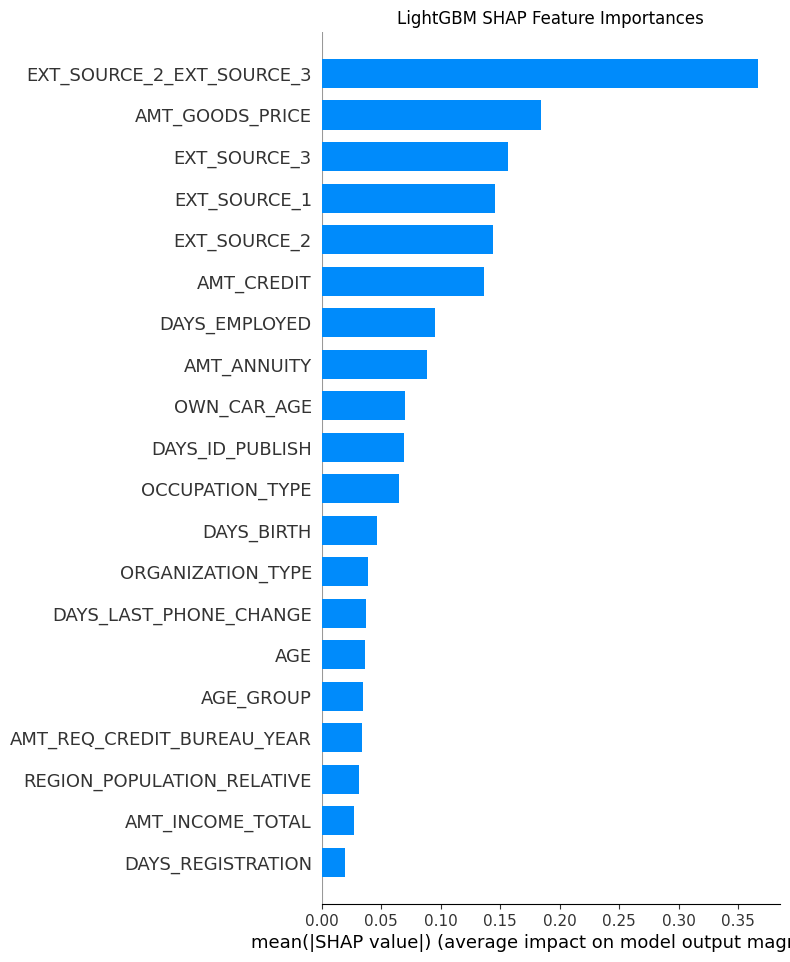


Updated RandomForest Feature Importances:
                        Feature  Importance
0     EXT_SOURCE_2_EXT_SOURCE_3    0.231287
1                  EXT_SOURCE_2    0.134866
2                  EXT_SOURCE_3    0.097869
3                  EXT_SOURCE_1    0.051787
4                           AGE    0.037856
5                 DAYS_EMPLOYED    0.036128
6                    DAYS_BIRTH    0.035338
7             DAYS_REGISTRATION    0.034398
8                   AMT_ANNUITY    0.033077
9                    AMT_CREDIT    0.031303
10         DAYS_ID_PUBLISH_YEAR    0.031300
11              DAYS_ID_PUBLISH    0.031004
12              AMT_GOODS_PRICE    0.030710
13  DAYS_LAST_PHONE_CHANGE_YEAR    0.025218
14       DAYS_LAST_PHONE_CHANGE    0.023843
15   REGION_POPULATION_RELATIVE    0.020660
16             AMT_INCOME_TOTAL    0.018703
17                  OWN_CAR_AGE    0.017696
18              OCCUPATION_TYPE    0.015032
19            ORGANIZATION_TYPE    0.013987
20   AMT_REQ_CREDIT_BUREAU_YEAR  

In [31]:
# ----------------------------#
#       Credit Default        #
#         Prediction           #
# ----------------------------#

# ----------------------------#
# 1. ライブラリのインポート    #
# ----------------------------#
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import shap

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.feature_selection import RFECV
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.utils.class_weight import compute_class_weight

# 警告メッセージを非表示にする
warnings.filterwarnings('ignore')

# ----------------------------#
# 2. データの読み込み          #
# ----------------------------#
# Google Colaboratoryで作業する場合のみ実行
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/compe2"

# データのパスを設定
INPUT_DIR = "./input/"

# データの読み込み
train = pd.read_csv(INPUT_DIR + "train.csv")
test = pd.read_csv(INPUT_DIR + "test.csv")
sample_sub = pd.read_csv(INPUT_DIR + "sample_submission.csv")

# データの基本情報
print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")

# 欠損値の確認
missing_train = train.isnull().sum().sort_values(ascending=False)
missing_test = test.isnull().sum().sort_values(ascending=False)

print("\nTrain Missing Values:\n", missing_train[missing_train > 0])
print("\nTest Missing Values:\n", missing_test[missing_test > 0])

# ----------------------------#
# 3. データのコピーと前処理    #
# ----------------------------#
# データのコピー
train_processed = train.copy()
test_processed = test.copy()

# 3.1. 数値型特徴量の補完（中央値）
num_cols = train_processed.select_dtypes(include=['float64', 'int64']).columns.tolist()
if 'TARGET' in num_cols:
    num_cols.remove('TARGET')  # 目的変数は除外

for col in num_cols:
    median = train_processed[col].median()
    train_processed[col].fillna(median, inplace=True)
    test_processed[col].fillna(median, inplace=True)

# 3.2. カテゴリ型特徴量の補完
cat_cols = train_processed.select_dtypes(include=['object']).columns.tolist()
for col in cat_cols:
    train_processed[col].fillna('Missing', inplace=True)
    test_processed[col].fillna('Missing', inplace=True)

# 3.3. 特定の特徴量の外れ値処理
# 例: OWN_CAR_AGEの外れ値処理（60以上を欠損値として扱い中央値で補完）
if 'OWN_CAR_AGE' in train_processed.columns:
    if train_processed['OWN_CAR_AGE'].max() >= 60:
        train_processed.loc[train_processed["OWN_CAR_AGE"] >= 60, "OWN_CAR_AGE"] = np.nan
        test_processed.loc[test_processed["OWN_CAR_AGE"] >= 60, "OWN_CAR_AGE"] = np.nan
        median_car_age = train_processed['OWN_CAR_AGE'].median()
        train_processed['OWN_CAR_AGE'].fillna(median_car_age, inplace=True)
        test_processed['OWN_CAR_AGE'].fillna(median_car_age, inplace=True)

# 再度欠損値を確認
print("\nAfter imputation, missing values in train:", train_processed.isnull().sum().max())

# ----------------------------#
# 4. カテゴリ型特徴量のエンコード#
# ----------------------------#
# 4.1. バイナリカテゴリ型特徴量のエンコード
binary_cols = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']
le = LabelEncoder()
for col in binary_cols:
    if col in train_processed.columns:
        train_processed[col] = le.fit_transform(train_processed[col])
        test_processed[col] = le.transform(test_processed[col])

# 4.2. その他のカテゴリ型特徴量のカウントエンコーディング
other_cat_cols = [col for col in cat_cols if col not in binary_cols]
for col in other_cat_cols:
    if col in train_processed.columns:
        freq_encoding = train_processed[col].value_counts()
        train_processed[col] = train_processed[col].map(freq_encoding)
        test_processed[col] = test_processed[col].map(freq_encoding)
        # 欠損値が発生した場合は0で埋める
        train_processed[col].fillna(0, inplace=True)
        test_processed[col].fillna(0, inplace=True)

# ----------------------------#
# 5. 数値型特徴量の外れ値処理  #
# ----------------------------#
# 例: AMT_INCOME_TOTALの外れ値をIQRで除外
if 'AMT_INCOME_TOTAL' in train_processed.columns:
    Q1 = train_processed['AMT_INCOME_TOTAL'].quantile(0.25)
    Q3 = train_processed['AMT_INCOME_TOTAL'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # 外れ値を中央値で補完
    train_processed['AMT_INCOME_TOTAL'] = np.where(
        (train_processed['AMT_INCOME_TOTAL'] < lower_bound) | (train_processed['AMT_INCOME_TOTAL'] > upper_bound),
        train_processed['AMT_INCOME_TOTAL'].median(),
        train_processed['AMT_INCOME_TOTAL']
    )

    test_processed['AMT_INCOME_TOTAL'] = np.where(
        (test_processed['AMT_INCOME_TOTAL'] < lower_bound) | (test_processed['AMT_INCOME_TOTAL'] > upper_bound),
        test_processed['AMT_INCOME_TOTAL'].median(),
        test_processed['AMT_INCOME_TOTAL']
    )

# ----------------------------#
# 6. 相関係数に基づく特徴量選択#
# ----------------------------#
# 相関マトリックスの計算
corr_matrix = train_processed.corr()

# ターゲットとの相関が高い特徴量を選択
target_corr = corr_matrix['TARGET'].abs().sort_values(ascending=False)
print("\nCorrelation with TARGET:")
print(target_corr)

# 相関が0.05以上の特徴量を選択（閾値は調整可能）
selected_features_corr = target_corr[target_corr > 0.05].index.tolist()

# 'TARGET'と'SK_ID_CURR'を除外（存在する場合のみ）
for col in ['TARGET', 'SK_ID_CURR']:
    if col in selected_features_corr:
        selected_features_corr.remove(col)

print(f"\nSelected Features based on Correlation ({len(selected_features_corr)}): {selected_features_corr}")

# ----------------------------#
# 7. モデルベースの特徴量選択  #
# ----------------------------#
# 説明変数と目的変数の分離
X_all = train_processed.drop(['SK_ID_CURR', 'TARGET'], axis=1)
y_all = train_processed['TARGET']

# RandomForestを用いた特徴量重要度の計算
rf = RandomForestClassifier(random_state=42, n_estimators=100)
rf.fit(X_all, y_all)

# 特徴量重要度の取得
importances = rf.feature_importances_
feature_importances_rf = pd.Series(importances, index=X_all.columns).sort_values(ascending=False)
print("\nRandomForest Feature Importances:")
print(feature_importances_rf)

# 重要度が上位20の特徴量を選択
selected_features_rf = feature_importances_rf[:20].index.tolist()
print(f"\nSelected Features based on RandomForest ({len(selected_features_rf)}): {selected_features_rf}")

# 相関係数とRandomForestで選択した特徴量の統合
selected_features = list(set(selected_features_corr) | set(selected_features_rf))
print(f"\nFinal Selected Features ({len(selected_features)}): {selected_features}")

# ----------------------------#
# 8. 特徴量エンジニアリング    #
# ----------------------------#
# 相互作用特徴量の追加
if 'EXT_SOURCE_2' in train_processed.columns and 'EXT_SOURCE_3' in train_processed.columns:
    train_processed['EXT_SOURCE_2_EXT_SOURCE_3'] = train_processed['EXT_SOURCE_2'] * train_processed['EXT_SOURCE_3']
    test_processed['EXT_SOURCE_2_EXT_SOURCE_3'] = test_processed['EXT_SOURCE_2'] * test_processed['EXT_SOURCE_3']
    selected_features.append('EXT_SOURCE_2_EXT_SOURCE_3')

# 年齢の計算（DAYS_BIRTHから）
if 'DAYS_BIRTH' in train_processed.columns:
    train_processed['AGE'] = -train_processed['DAYS_BIRTH'] / 365
    test_processed['AGE'] = -test_processed['DAYS_BIRTH'] / 365
    selected_features.append('AGE')

# DAYS_ID_PUBLISHを年数に変換
if 'DAYS_ID_PUBLISH' in train_processed.columns:
    train_processed['DAYS_ID_PUBLISH_YEAR'] = train_processed['DAYS_ID_PUBLISH'] / 365
    test_processed['DAYS_ID_PUBLISH_YEAR'] = test_processed['DAYS_ID_PUBLISH'] / 365
    selected_features.append('DAYS_ID_PUBLISH_YEAR')

# DAYS_LAST_PHONE_CHANGEを年数に変換
if 'DAYS_LAST_PHONE_CHANGE' in train_processed.columns:
    train_processed['DAYS_LAST_PHONE_CHANGE_YEAR'] = train_processed['DAYS_LAST_PHONE_CHANGE'] / 365
    test_processed['DAYS_LAST_PHONE_CHANGE_YEAR'] = test_processed['DAYS_LAST_PHONE_CHANGE'] / 365
    selected_features.append('DAYS_LAST_PHONE_CHANGE_YEAR')

# 最近1年以内に電話変更があったかを示すバイナリ特徴量
if 'DAYS_LAST_PHONE_CHANGE_YEAR' in train_processed.columns:
    train_processed['PHONE_CHANGE_RECENT'] = (train_processed['DAYS_LAST_PHONE_CHANGE_YEAR'] <= 1).astype(int)
    test_processed['PHONE_CHANGE_RECENT'] = (test_processed['DAYS_LAST_PHONE_CHANGE_YEAR'] <= 1).astype(int)
    selected_features.append('PHONE_CHANGE_RECENT')

# 年齢グループの作成
if 'AGE' in train_processed.columns:
    train_processed['AGE_GROUP'] = pd.cut(train_processed['AGE'], bins=[0, 25, 35, 45, 55, 65, 100], labels=False)
    test_processed['AGE_GROUP'] = pd.cut(test_processed['AGE'], bins=[0, 25, 35, 45, 55, 65, 100], labels=False)
    selected_features.append('AGE_GROUP')

# ----------------------------#
# 9. 再度特徴量選択と重複の除去#
# ----------------------------#
# 再度重複を除去
selected_features = list(set(selected_features))
print(f"\nSelected Features after Engineering ({len(selected_features)}): {selected_features}")

# ----------------------------#
# 10. 特徴量のスケーリング      #
# ----------------------------#
# スケーリング
scaler = StandardScaler()
train_processed[selected_features] = scaler.fit_transform(train_processed[selected_features])
test_processed[selected_features] = scaler.transform(test_processed[selected_features])

# ----------------------------#
# 11. 低重要度特徴量の除去    #
# ----------------------------#
# 低重要度特徴量のリスト（例）
low_importance_features = ['NAME_INCOME_TYPE', 'REGION_RATING_CLIENT_W_CITY', 'REGION_RATING_CLIENT', 'CODE_GENDER']
selected_features = [feat for feat in selected_features if feat not in low_importance_features]
print(f"\nSelected Features after Removing Low Importance ({len(selected_features)}): {selected_features}")

# ----------------------------#
# 12. モデルの訓練と評価      #
# ----------------------------#
# 目的変数と説明変数の分割
X = train_processed[selected_features]
y = train_processed['TARGET']
X_test_final = test_processed[selected_features]

# 訓練データと検証データに分割
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# クラス不均衡への対処：クラス重みの計算
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
print(f"\nClass Weights: {class_weight_dict}")

# モデルの初期化
models = {
    'LogisticRegression': LogisticRegression(random_state=42, max_iter=1000),
    'MLPClassifier': MLPClassifier(random_state=42, max_iter=500),
    'RandomForest': RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10, min_samples_split=10),
    'XGBoost': XGBClassifier(
        random_state=42,
        n_estimators=200,
        learning_rate=0.2,
        max_depth=3,
        use_label_encoder=False,
        eval_metric='auc',
        scale_pos_weight=class_weight_dict.get(1, 1)
    ),
    'LightGBM': LGBMClassifier(
        random_state=42,
        n_estimators=300,
        learning_rate=0.05,
        max_depth=5,
        min_child_samples=30,
        subsample=0.8,
        colsample_bytree=0.8,
        class_weight='balanced'
    )
}

# 各モデルのトレーニングと評価
model_performance = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)

    # 訓練データの予測
    y_train_pred = model.predict_proba(X_train)[:, 1]
    # 検証データの予測
    y_valid_pred = model.predict_proba(X_valid)[:, 1]

    # AUCスコアの計算
    train_auc = roc_auc_score(y_train, y_train_pred)
    valid_auc = roc_auc_score(y_valid, y_valid_pred)

    model_performance[name] = {
        'Train AUC': train_auc,
        'Valid AUC': valid_auc
    }
    print(f"{name} - Train AUC: {train_auc:.4f}, Valid AUC: {valid_auc:.4f}")

# モデルの性能比較
performance_df = pd.DataFrame(model_performance).T
print("\nModel Performance:")
print(performance_df)

# ----------------------------#
# 13. アンサンブルモデルの構築#
# ----------------------------#
# Voting Classifierの構築
voting_clf = VotingClassifier(
    estimators=[
        ('lr', models['LogisticRegression']),
        ('mlp', models['MLPClassifier']),
        ('rf', models['RandomForest']),
        ('xgb', models['XGBoost']),
        ('lgbm', models['LightGBM'])
    ],
    voting='soft'  # ソフト投票
)

print("\nTraining Voting Classifier...")
voting_clf.fit(X_train, y_train)

# アンサンブルモデルの予測
y_train_pred_vc = voting_clf.predict_proba(X_train)[:, 1]
y_valid_pred_vc = voting_clf.predict_proba(X_valid)[:, 1]

# AUCスコアの計算
train_auc_vc = roc_auc_score(y_train, y_train_pred_vc)
valid_auc_vc = roc_auc_score(y_valid, y_valid_pred_vc)

print(f"VotingClassifier - Train AUC: {train_auc_vc:.4f}, Valid AUC: {valid_auc_vc:.4f}")

# ----------------------------#
# 14. スタッキングモデルの構築#
# ----------------------------#
# Stacking Classifierの構築
estimators_stack = [
    ('rf', models['RandomForest']),
    ('xgb', models['XGBoost']),
    ('lgbm', models['LightGBM'])
]

stacking_clf = StackingClassifier(
    estimators=estimators_stack,
    final_estimator=LGBMClassifier(
        random_state=42,
        n_estimators=200,
        learning_rate=0.05,
        max_depth=5,
        min_child_samples=30,
        subsample=0.8,
        colsample_bytree=0.8,
        class_weight='balanced'
    ),
    cv=5,
    n_jobs=-1
)

print("\nTraining Stacking Classifier...")
stacking_clf.fit(X_train, y_train)

# スタッキングモデルの予測
y_valid_pred_stack = stacking_clf.predict_proba(X_valid)[:, 1]

# AUCスコアの計算
valid_auc_stack = roc_auc_score(y_valid, y_valid_pred_stack)
print(f"StackingClassifier - Valid AUC: {valid_auc_stack:.4f}")

# ----------------------------#
# 15. ハイパーパラメータチューニング#
# ----------------------------#
# 15.1. XGBoostのハイパーパラメータチューニング
param_grid_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

xgb = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='auc',
    scale_pos_weight=class_weight_dict.get(1, 1)
)

grid_search_xgb = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid_xgb,
    scoring='roc_auc',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    verbose=1,
    n_jobs=-1
)

print("\nStarting Grid Search for XGBoost...")
grid_search_xgb.fit(X_train, y_train)

print(f"Best Parameters for XGBoost: {grid_search_xgb.best_params_}")
print(f"Best CV AUC for XGBoost: {grid_search_xgb.best_score_:.4f}")

# 最適なモデルで再評価
best_xgb = grid_search_xgb.best_estimator_
y_valid_pred_best_xgb = best_xgb.predict_proba(X_valid)[:, 1]
valid_auc_best_xgb = roc_auc_score(y_valid, y_valid_pred_best_xgb)
print(f"Best XGBoost Valid AUC: {valid_auc_best_xgb:.4f}")

# 15.2. LightGBMのハイパーパラメータチューニング
param_grid_lgbm = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [5, 7, 9],
    'min_child_samples': [20, 30, 40],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

lgbm = LGBMClassifier(random_state=42, class_weight='balanced')

grid_search_lgbm = GridSearchCV(
    estimator=lgbm,
    param_grid=param_grid_lgbm,
    scoring='roc_auc',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    verbose=1,
    n_jobs=-1
)

print("\nStarting Grid Search for LightGBM...")
grid_search_lgbm.fit(X_train, y_train)

print(f"Best Parameters for LightGBM: {grid_search_lgbm.best_params_}")
print(f"Best CV AUC for LightGBM: {grid_search_lgbm.best_score_:.4f}")

# 最適なモデルで再評価
best_lgbm = grid_search_lgbm.best_estimator_
y_valid_pred_best_lgbm = best_lgbm.predict_proba(X_valid)[:, 1]
valid_auc_best_lgbm = roc_auc_score(y_valid, y_valid_pred_best_lgbm)
print(f"Best LightGBM Valid AUC: {valid_auc_best_lgbm:.4f}")

# ----------------------------#
# 16. モデルの再訓練と再評価  #
# ----------------------------#
# 更新されたXGBoostとLightGBMをモデルに反映
models_updated = {
    'LogisticRegression': models['LogisticRegression'],
    'MLPClassifier': models['MLPClassifier'],
    'RandomForest': models['RandomForest'],
    'XGBoost': best_xgb,
    'LightGBM': best_lgbm
}

# 再度各モデルのトレーニングと評価
model_performance_updated = {}

for name, model in models_updated.items():
    print(f"\nTraining {name} with tuned parameters...")
    model.fit(X_train, y_train)

    # 訓練データの予測
    y_train_pred = model.predict_proba(X_train)[:, 1]
    # 検証データの予測
    y_valid_pred = model.predict_proba(X_valid)[:, 1]

    # AUCスコアの計算
    train_auc = roc_auc_score(y_train, y_train_pred)
    valid_auc = roc_auc_score(y_valid, y_valid_pred)

    model_performance_updated[name] = {
        'Train AUC': train_auc,
        'Valid AUC': valid_auc
    }
    print(f"{name} - Train AUC: {train_auc:.4f}, Valid AUC: {valid_auc:.4f}")

# モデルの性能比較
performance_df_updated = pd.DataFrame(model_performance_updated).T
print("\nUpdated Model Performance:")
print(performance_df_updated)

# ----------------------------#
# 17. アンサンブルモデルの再構築#
# ----------------------------#
# 更新されたVoting Classifierの構築
voting_clf_updated = VotingClassifier(
    estimators=[
        ('lr', models_updated['LogisticRegression']),
        ('mlp', models_updated['MLPClassifier']),
        ('rf', models_updated['RandomForest']),
        ('xgb', models_updated['XGBoost']),
        ('lgbm', models_updated['LightGBM'])
    ],
    voting='soft'  # ソフト投票
)

print("\nTraining Updated Voting Classifier...")
voting_clf_updated.fit(X_train, y_train)

# アンサンブルモデルの予測
y_train_pred_vc_updated = voting_clf_updated.predict_proba(X_train)[:, 1]
y_valid_pred_vc_updated = voting_clf_updated.predict_proba(X_valid)[:, 1]

# AUCスコアの計算
train_auc_vc_updated = roc_auc_score(y_train, y_train_pred_vc_updated)
valid_auc_vc_updated = roc_auc_score(y_valid, y_valid_pred_vc_updated)

print(f"Updated VotingClassifier - Train AUC: {train_auc_vc_updated:.4f}, Valid AUC: {valid_auc_vc_updated:.4f}")

# ----------------------------#
# 18. クロスバリデーションの導入 #
# ----------------------------#
# Stratified K-Fold Cross-Validationの設定
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# LightGBMのクロスバリデーション
cv_scores_lgbm = cross_val_score(best_lgbm, X, y, cv=cv, scoring='roc_auc', n_jobs=-1)
print(f"\nLightGBM Cross-Validation AUC Scores: {cv_scores_lgbm}")
print(f"LightGBM Mean CV AUC: {cv_scores_lgbm.mean():.4f} ± {cv_scores_lgbm.std():.4f}")

# ----------------------------#
# 19. スタッキングモデルの再構築#
# ----------------------------#
# Stacking Classifierの再構築
stacking_clf_updated = StackingClassifier(
    estimators=estimators_stack,
    final_estimator=LGBMClassifier(
        random_state=42,
        n_estimators=200,
        learning_rate=0.05,
        max_depth=5,
        min_child_samples=30,
        subsample=0.8,
        colsample_bytree=0.8,
        class_weight='balanced'
    ),
    cv=5,
    n_jobs=-1
)

print("\nTraining Enhanced Stacking Classifier...")
stacking_clf_updated.fit(X_train, y_train)

# スタッキングモデルの評価
y_valid_pred_stack_updated = stacking_clf_updated.predict_proba(X_valid)[:, 1]
valid_auc_stack_updated = roc_auc_score(y_valid, y_valid_pred_stack_updated)
print(f"Enhanced StackingClassifier - Valid AUC: {valid_auc_stack_updated:.4f}")

# ----------------------------#
# 20. 最終モデルによる予測と提出ファイルの作成#
# ----------------------------#
# 最適なモデルの選択（ここではStackingClassifierを使用）
final_model = stacking_clf_updated  # または voting_clf_updated

# 全データで再トレーニング
final_model.fit(X, y)

# テストデータに対する予測
test_pred_final = final_model.predict_proba(X_test_final)[:, 1]

# 提出用ファイルの作成
sample_sub['TARGET'] = test_pred_final
sample_sub.to_csv('submission_final_enhanced_stack.csv', index=False)
print("\nsubmission_final_enhanced_stack.csv が作成されました。")

# ----------------------------#
# 21. 特徴量重要度の確認      #
# ----------------------------#
# RandomForestの特徴量重要度
rf_importances = pd.Series(models_updated['RandomForest'].feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nRandomForest Feature Importances:")
print(rf_importances.to_frame('Importance').reset_index().rename(columns={'index': 'Feature'}))

# XGBoostの特徴量重要度
xgb_importances = pd.Series(models_updated['XGBoost'].feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nXGBoost Feature Importances:")
print(xgb_importances.to_frame('Importance').reset_index().rename(columns={'index': 'Feature'}))

# LightGBMの特徴量重要度
lgbm_importances = pd.Series(models_updated['LightGBM'].feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nLightGBM Feature Importances:")
print(lgbm_importances.to_frame('Importance').reset_index().rename(columns={'index': 'Feature'}))

# ----------------------------#
# 22. クロスバリデーションの詳細 #
# ----------------------------#
# 既にLightGBMのクロスバリデーションを実施済み

# ----------------------------#
# 23. モデルの解釈性の向上   #
# ----------------------------#
# SHAP値を用いた特徴量の解釈（LightGBM）
print("\nSHAP Summary Plot for LightGBM:")
explainer = shap.TreeExplainer(best_lgbm)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar", show=False)
plt.title('LightGBM SHAP Feature Importances')
plt.savefig('shap_summary_lightgbm.png')
plt.show()

# ----------------------------#
# 24. 最終的な特徴量重要度の確認#
# ----------------------------#
# 再度RandomForestの特徴量重要度
print("\nUpdated RandomForest Feature Importances:")
print(rf_importances.to_frame('Importance').reset_index().rename(columns={'index': 'Feature'}))

# 再度XGBoostの特徴量重要度
print("\nUpdated XGBoost Feature Importances:")
print(xgb_importances.to_frame('Importance').reset_index().rename(columns={'index': 'Feature'}))

# 再度LightGBMの特徴量重要度
print("\nUpdated LightGBM Feature Importances:")
print(lgbm_importances.to_frame('Importance').reset_index().rename(columns={'index': 'Feature'}))

# ----------------------------#
# 25. 終了メッセージ            #
# ----------------------------#
print("\n全てのプロセスが完了しました。提出ファイル 'submission_final_enhanced_stack.csv' を確認してください。")



In [4]:
!pip install pandas numpy scikit-learn lightgbm xgboost category_encoders imbalanced-learn matplotlib seaborn

In [16]:
!pip install tabgan==1.3.3

In [ ]:
# ライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# モデル関連
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline

# エンコーディング
import category_encoders as ce

# クラス不均衡対策
from imblearn.over_sampling import SMOTE

# LightGBM
import lightgbm as lgb

# XGBoost
import xgboost as xgb

# 警告の非表示
import warnings
warnings.filterwarnings('ignore')

# データの読み込み
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/compe2"

# データのパスを設定
INPUT_DIR = "./input/"

# データの読み込み
train = pd.read_csv(INPUT_DIR + "train.csv")
test = pd.read_csv(INPUT_DIR + "test.csv")
sample_sub = pd.read_csv(INPUT_DIR + "sample_submission.csv")


# ターゲット変数の分離
y = train['TARGET']
X = train.drop(['TARGET'], axis=1)

# テストデータの特徴量
X_test = test.copy()

# データの確認
print("トレーニングデータの形状:", X.shape)
print("テストデータの形状:", X_test.shape)

# 欠損値の確認
print("\nトレーニングデータの欠損値:\n", X.isnull().sum()[X.isnull().sum() > 0])
print("\nテストデータの欠損値:\n", X_test.isnull().sum()[X_test.isnull().sum() > 0])

# 欠損値の補完
# 数値特徴量は中央値で補完、カテゴリ特徴量は最頻値で補完
numerical_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

X[numerical_features] = X[numerical_features].fillna(X[numerical_features].median())
X_test[numerical_features] = X_test[numerical_features].fillna(X_test[numerical_features].median())

for col in categorical_features:
    X[col] = X[col].fillna(X[col].mode()[0])
    X_test[col] = X_test[col].fillna(X_test[col].mode()[0])

# 再度欠損値の確認
print("\n欠損値補完後のトレーニングデータの欠損値:\n", X.isnull().sum()[X.isnull().sum() > 0])
print("\n欠損値補完後のテストデータの欠損値:\n", X_test.isnull().sum()[X_test.isnull().sum() > 0])

# 特徴量エンジニアリングの強化
# 1. DAYS_EMPLOYED を YEARS_EMPLOYED に変換
X['YEARS_EMPLOYED'] = X['DAYS_EMPLOYED'] / 365
X_test['YEARS_EMPLOYED'] = X_test['DAYS_EMPLOYED'] / 365

# 2. 金額関連特徴量に対数変換
amount_features = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE']
for feature in amount_features:
    X[feature + '_LOG'] = np.log1p(X[feature])
    X_test[feature + '_LOG'] = np.log1p(X_test[feature])

# 3. 相互作用特徴量の追加
X['EXT_SOURCE_2_EXT_SOURCE_3'] = X['EXT_SOURCE_2'] * X['EXT_SOURCE_3']
X_test['EXT_SOURCE_2_EXT_SOURCE_3'] = X_test['EXT_SOURCE_2'] * X_test['EXT_SOURCE_3']

# 4. 年齢グループの作成
X['AGE_GROUP'] = pd.cut(X['DAYS_BIRTH'] / 365, bins=[0, 25, 35, 45, 55, 100], labels=False)
X_test['AGE_GROUP'] = pd.cut(X_test['DAYS_BIRTH'] / 365, bins=[0, 25, 35, 45, 55, 100], labels=False)

# 5. 近年の電話変更フラグの作成
X['PHONE_CHANGE_RECENT'] = X['DAYS_LAST_PHONE_CHANGE'] < -365
X_test['PHONE_CHANGE_RECENT'] = X_test['DAYS_LAST_PHONE_CHANGE'] < -365

# 6. 年単位での電話変更
X['DAYS_LAST_PHONE_CHANGE_YEAR'] = X['DAYS_LAST_PHONE_CHANGE'] / 365
X_test['DAYS_LAST_PHONE_CHANGE_YEAR'] = X_test['DAYS_LAST_PHONE_CHANGE'] / 365

# 7. ID公開年の作成
X['DAYS_ID_PUBLISH_YEAR'] = X['DAYS_ID_PUBLISH'] / 365
X_test['DAYS_ID_PUBLISH_YEAR'] = X_test['DAYS_ID_PUBLISH'] / 365

# 不要な特徴量の削除（例として、元の DAYS_EMPLOYED を削除）
X.drop(['DAYS_EMPLOYED'], axis=1, inplace=True)
X_test.drop(['DAYS_EMPLOYED'], axis=1, inplace=True)

# カテゴリ変数のエンコーディング手法の試行
# a. ターゲットエンコーディング
# b. One-Hotエンコーディング

# ターゲットエンコーディング
target_encoder = ce.TargetEncoder(cols=categorical_features)
X_encoded_target = target_encoder.fit_transform(X, y)
X_test_encoded_target = target_encoder.transform(X_test)

# One-Hotエンコーディング
X_encoded_ohe = pd.get_dummies(X, columns=categorical_features, drop_first=True)
X_test_encoded_ohe = pd.get_dummies(X_test, columns=categorical_features, drop_first=True)

# トレーニングデータとテストデータでカラムを揃える
X_encoded_ohe, X_test_encoded_ohe = X_encoded_ohe.align(X_test_encoded_ohe, join='left', axis=1, fill_value=0)

# どちらのエンコーディング手法を使用するか選択（例としてターゲットエンコーディングを使用）
X_final = X_encoded_target
X_test_final = X_test_encoded_target

# 特徴量とターゲットの再確認
print("\n最終的なトレーニングデータの形状:", X_final.shape)
print("最終的なテストデータの形状:", X_test_final.shape)

# トレーニングデータと検証データへの分割
X_train, X_valid, y_train, y_valid = train_test_split(
    X_final, y, test_size=0.2, random_state=42, stratify=y
)

print("\nトレーニングセットの形状:", X_train.shape)
print("検証セットの形状:", X_valid.shape)

# クラス不均衡の処理（クラス重みの設定）
class_weights = {0: 0.5439110070257611, 1: 6.193333333333333}

# LightGBMのハイパーパラメータ調整
# ハイパーパラメータのグリッド設定
lgb_param_grid = {
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [6, 9, 12],
    'min_child_samples': [20, 50, 100],
    'num_leaves': [31, 50, 100],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# LightGBMの基本モデルを設定
lgb_model = lgb.LGBMClassifier(
    objective='binary',
    metric='auc',
    class_weight=class_weights,
    n_jobs=-1,
    random_state=42
)

# GridSearchCVを使用してハイパーパラメータチューニング
grid_search_lgb = GridSearchCV(
    estimator=lgb_model,
    param_grid=lgb_param_grid,
    scoring='roc_auc',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# グリッドサーチの実行
grid_search_lgb.fit(X_train, y_train)

# 最適なパラメータの表示
print("\n最適なLightGBMのパラメータ:", grid_search_lgb.best_params_)
print("最適なLightGBMのCV AUC:", grid_search_lgb.best_score_)

# 最適なLightGBMモデルの取得
best_lgb = grid_search_lgb.best_estimator_

# その他のモデルの定義
# Logistic Regression
lr = LogisticRegression(
    class_weight=class_weights,
    random_state=42,
    max_iter=1000
)

# MLP Classifier
mlp = MLPClassifier(
    hidden_layer_sizes=(100,),
    activation='relu',
    solver='adam',
    alpha=0.0001,
    batch_size='auto',
    learning_rate='constant',
    learning_rate_init=0.001,
    max_iter=200,
    random_state=42
)

# Random Forest
rf = RandomForestClassifier(
    n_estimators=100,
    class_weight=class_weights,
    random_state=42,
    n_jobs=-1
)

# XGBoost
xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    use_label_encoder=False,
    scale_pos_weight=class_weights[0]/class_weights[1],
    random_state=42,
    n_jobs=-1
)

# 再度LightGBMの定義（ハイパーパラメータ調整済み）
lgb_final = best_lgb

# モデルの訓練
print("\nモデルの訓練を開始します...")

# Logistic Regression
lr.fit(X_train, y_train)
y_pred_lr = lr.predict_proba(X_valid)[:,1]
auc_lr = roc_auc_score(y_valid, y_pred_lr)
print(f"LogisticRegression - Valid AUC: {auc_lr:.4f}")

# MLP Classifier
mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict_proba(X_valid)[:,1]
auc_mlp = roc_auc_score(y_valid, y_pred_mlp)
print(f"MLPClassifier - Valid AUC: {auc_mlp:.4f}")

# Random Forest
rf.fit(X_train, y_train)
y_pred_rf = rf.predict_proba(X_valid)[:,1]
auc_rf = roc_auc_score(y_valid, y_pred_rf)
print(f"RandomForest - Valid AUC: {auc_rf:.4f}")

# XGBoost
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict_proba(X_valid)[:,1]
auc_xgb = roc_auc_score(y_valid, y_pred_xgb)
print(f"XGBoost - Valid AUC: {auc_xgb:.4f}")

# LightGBM
lgb_final.fit(X_train, y_train)
y_pred_lgb = lgb_final.predict_proba(X_valid)[:,1]
auc_lgb = roc_auc_score(y_valid, y_pred_lgb)
print(f"LightGBM - Valid AUC: {auc_lgb:.4f}")

# モデルパフォーマンスのまとめ
model_performance = pd.DataFrame({
    'Model': ['LogisticRegression', 'MLPClassifier', 'RandomForest', 'XGBoost', 'LightGBM'],
    'Valid AUC': [auc_lr, auc_mlp, auc_rf, auc_xgb, auc_lgb]
})

print("\nモデルパフォーマンス:\n", model_performance)

# アンサンブルモデルの構築
# Voting Classifier
voting_clf = VotingClassifier(
    estimators=[
        ('lr', lr),
        ('mlp', mlp),
        ('rf', rf),
        ('xgb', xgb),
        ('lgb', lgb_final)
    ],
    voting='soft',
    n_jobs=-1
)

voting_clf.fit(X_train, y_train)
y_pred_voting = voting_clf.predict_proba(X_valid)[:,1]
auc_voting = roc_auc_score(y_valid, y_pred_voting)
print(f"\nVotingClassifier - Valid AUC: {auc_voting:.4f}")

# Stacking Classifier
estimators = [
    ('rf', rf),
    ('xgb', xgb),
    ('lgb', lgb_final)
]

stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=lgb_final,
    passthrough=False,
    cv=5,
    n_jobs=-1
)

stacking_clf.fit(X_train, y_train)
y_pred_stacking = stacking_clf.predict_proba(X_valid)[:,1]
auc_stacking = roc_auc_score(y_valid, y_pred_stacking)
print(f"StackingClassifier - Valid AUC: {auc_stacking:.4f}")

# アンサンブルモデルのパフォーマンス追加
model_performance = model_performance.append({
    'Model': 'VotingClassifier',
    'Valid AUC': auc_voting
}, ignore_index=True)

model_performance = model_performance.append({
    'Model': 'StackingClassifier',
    'Valid AUC': auc_stacking
}, ignore_index=True)

print("\n更新後のモデルパフォーマンス:\n", model_performance)

# ハイパーパラメータチューニング
# 既にLightGBMのチューニングを行っているため、他のモデルも必要に応じてチューニング可能

# クロスバリデーションの実施（LightGBM）
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(lgb_final, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
print(f"\nLightGBM Cross-Validation AUC Scores: {cv_scores}")
print(f"LightGBM Mean CV AUC: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# 特徴量重要度の可視化
# LightGBM
importances_lgb = pd.DataFrame({
    'Feature': X_final.columns,
    'Importance': lgb_final.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 20))
sns.barplot(x='Importance', y='Feature', data=importances_lgb.head(30))
plt.title('LightGBM Feature Importances')
plt.tight_layout()
plt.show()

# SHAPによるモデル解釈
# LightGBMモデル用のSHAP値計算
explainer = shap.Explainer(lgb_final)
shap_values = explainer(X_valid)

# SHAPサマリープロット
shap.summary_plot(shap_values, X_valid, plot_type="bar")

# 最終モデルによるテストデータの予測
# ここではVotingClassifierを使用（他のモデルも可能）
final_model = voting_clf
y_test_pred = final_model.predict_proba(X_test_final)[:,1]

# 提出用ファイルの作成
submission = pd.DataFrame({
    'SK_ID_CURR': test['SK_ID_CURR'],
    'TARGET': y_test_pred
})

submission.to_csv('submission_final_enhanced_stack.csv', index=False)
print("\nsubmission_final_enhanced_stack.csv が作成されました。")
ｖ






Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/compe2
トレーニングデータの形状: (171202, 50)
テストデータの形状: (61500, 50)

トレーニングデータの欠損値:
 FLAG_OWN_CAR                   34241
FLAG_OWN_REALTY                34241
AMT_ANNUITY                        6
AMT_GOODS_PRICE                  163
NAME_TYPE_SUITE                  747
OWN_CAR_AGE                   112992
OCCUPATION_TYPE                53745
CNT_FAM_MEMBERS                    2
EXT_SOURCE_1                  118928
EXT_SOURCE_2                     369
EXT_SOURCE_3                   54586
OBS_30_CNT_SOCIAL_CIRCLE         560
DEF_30_CNT_SOCIAL_CIRCLE         560
OBS_60_CNT_SOCIAL_CIRCLE         560
DEF_60_CNT_SOCIAL_CIRCLE         560
DAYS_LAST_PHONE_CHANGE             1
AMT_REQ_CREDIT_BUREAU_HOUR     23116
AMT_REQ_CREDIT_BUREAU_MON      23116
AMT_REQ_CREDIT_BUREAU_QRT      23116
AMT_REQ_CREDIT_BUREAU_YEAR     23116
dtype: int64

テストデータの欠損値:
 FLAG_OW